In [11]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict
import argparse
import ast
import sys
import gzip
import csv
import pprint
import pandas as pd
import neet.sensitivity as ns
import neet.boolean as nn
from neet.boolean.examples import c_elegans
import neet as neet

from scipy import stats
import scipy as sp
import community
from scipy.spatial.distance import pdist, squareform
from sklearn import datasets
from matplotlib import patches

from network_ei import *
from causal_emergence import *
from get_motifs import *

import matplotlib.patches as mpatches
from matplotlib import gridspec
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

%matplotlib inline

In [2]:
def draw_adjacency_matrix(G, node_order=None, partitions=[], colors=[]):
    """
    - G is a netorkx graph
    - node_order (optional) is a list of nodes, where each node in G
          appears exactly once
    - partitions is a list of node lists, where each node in G appears
          in exactly one node list
    - colors is a list of strings indicating what color each
          partition should be
    If partitions is specified, the same number of colors needs to be
    specified.
    """
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)
    N = G.number_of_nodes()

    fig = plt.figure(figsize=(12, 12)) # in inches
    plt.imshow(adjacency_matrix, cmap="Greys", interpolation="none")

    plt.xticks(np.arange(0, N, 1), []);
    plt.yticks(np.arange(0, N, 1), []);
    plt.xticks(np.arange(-.5, N-.5, 1), []);
    plt.yticks(np.arange(-.5, N-.5, 1), []);
    plt.grid(color='darkgrey', linestyle='-', linewidth=0.5)
    
    assert len(partitions) == len(colors)
    ax = plt.gca()
    for partition, color in zip(partitions, colors):
        current_idx = 0
        for module in partition:
            ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                          len(module), # Width
                                          len(module), # Height
                                          facecolor="none",
                                          edgecolor=color,
                                          linewidth=3, alpha=0.8))
            current_idx += len(module)
            
def assignmentArray_to_lists(assignment_array):
    by_attribute_value = defaultdict(list)
    for node_index, attribute_value in enumerate(assignment_array.values()):
        by_attribute_value[attribute_value].append(node_index)
    return by_attribute_value.values()

In [3]:
colors = ["#91b43f","#7463cd","#54bc5b","#c560c7","#49925d","#cf4085","#49bfba","#cf4d2b","#6f8bce","#dd862f","#98558b",
"#c7a745","#dd85a8", "#777d35","#c64855","#9b5e2f","#e0906e"]

In [6]:
header_mapping = dict(zip(colHeaders, ['NetworkID', 'N', 'URL_paper', 'URL_data', 
                      'PaperCitation', 'PaperJournal', 'PaperTitle', 'PaperYear',
                      'System', 'InteractionsFromLit', 'InferredInteractionsFromLit', 
                      'InferredInteractionsFromExp', 'ExpPerformedForPape']))

In [7]:
# get metadata

with open('../data/network-metadata.csv', mode='r', errors='ignore') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line_count = 0
    out_dict = {}
    for row in csv_reader:
        if line_count == 0:
            colHeaders = list(row)
            for i in colHeaders:
                out_dict[header_mapping[i]] = []
            line_count += 1
        else:
            count = 0
            vals = list(row.values())
            for i in out_dict.keys():
                if i=='N' or i=='PaperYear':
                    out_dict[i].append(int(vals[count]))
                else:
                    out_dict[i].append(vals[count])
                count += 1
            line_count += 1

In [8]:
out_dict['URL_data']

['https://cellcollective.org/#2681/cell-cycle-transcription-by-coupled-cdk-and-network-oscillators',
 'https://cellcollective.org/#2668/toll-pathway-of-drosophila-signaling-pathway',
 'https://cellcollective.org/#5731/metabolic-interactions-in-the-gut-microbiome',
 'https://cellcollective.org/#5128/lac-operon',
 'https://cellcollective.org/#6885:1/regulation-of-the-larabinose-operon-of-escherichia-coli/1',
 'https://cellcollective.org/#4837:1/arabidopsis-thaliana-cell-cycle/1',
 'https://cellcollective.org/#2136/cardiac-development',
 'https://cellcollective.org/#4790:1/fanconi-anemia-and-checkpoint-recovery/1',
 'https://cellcollective.org/#4706/predicting-variabilities-in-cardiac-gene',
 'https://cellcollective.org/#2699/bt474-breast-cell-line-shortterm-erbb-network',
 'https://cellcollective.org/#2700:1/hcc1954-breast-cell-line-shortterm-erbb-network/1',
 'https://cellcollective.org/#2202:1/neurotransmitter-signaling-pathway/1',
 'https://cellcollective.org/#2701:1/skbr3-breast-cell

_______________________

In [10]:
def get_macro(G, macro_mapping, p0=0):
    """
    Given an input graph and a micro-to-macro mapping, output a macro transition matrix.
    - param G: current micro graph
    - param macro_mapping: a dictionary with {micro_node:macro_node}
    - param p0: smallest probability
    
    - output: Macro, a macro-level transition-probability matrix
    """
    # might have to assert node_labels to be integers
    G = prepare_network(G,p0=p0)
    micro_network_size = G.number_of_nodes()
    micro_Wout = get_Wout_full(G, p0)
    micro_nodes = np.unique(list(macro_mapping.keys()))
    nodes_in_macro_network = np.unique(list(macro_mapping.values()))

    macro_network_size = len(nodes_in_macro_network)
    macro_nodes = nodes_in_macro_network[nodes_in_macro_network > micro_network_size-1]
    n_macro = len(macro_nodes)
    
    if n_macro==0:
        return micro_Wout
    
    micro_to_macro_list = []
    for macro_i in range(n_macro):
        micro_in_macro_i = [k for k,v in macro_mapping.items() if v==macro_nodes[macro_i]]
        micro_to_macro_list.append(micro_in_macro_i)
    
    # get new rows
    macro_row_list = []
    for macro_i in micro_to_macro_list:
        macro_row_list.append(sum(micro_Wout[macro_i,:]))
    
    macro_rows = np.vstack(macro_row_list)

    # get new cols
    macro_col_list = []
    for macro_i in micro_to_macro_list:
        macro_col_list.append(sum(micro_Wout.T[macro_i,:]))

    macro_cols = np.vstack(macro_col_list)    
    macro_cols = macro_cols.T
    
    # get stubby diagonal square in the bottom right
    macro_bottom_right = np.zeros((n_macro,n_macro))
    for macro_i in range(n_macro):
        for macro_j in range(n_macro):
            macro_bottom_right[macro_i, macro_j] = sum(macro_row_list[macro_i][micro_to_macro_list[macro_j]])

    # put them all together in a matrix that is too big
    too_big_macro = np.block([[micro_Wout, macro_cols], [macro_rows, macro_bottom_right]])
    
    macro_out = too_big_macro[nodes_in_macro_network,:][:,nodes_in_macro_network]
    
    Macro = macro_out / macro_out.sum(axis=1)[:, np.newaxis]
    
    
    return Macro

# PRINT VERSION, WORKS
def causal_emergence(G, p0=0, thresh=0.0001):
    """
    Given a micro-scale network, iterate through possible macro-groupings and look for causal emergence.
    - param G: a networkx object or adjacency matrix or TPM
    - param p0: smallest probability
    
    - output Gm: a macro-scale network object with higher EI than G
    """
    G = prepare_network(G, p0) # makes the network weighted, directed if it's not already
    current_ei = get_ei(G, p0)
    micro_nodes_left = list(G.nodes())
    micros_that_have_been_macroed = []
    macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))    
    print("Starting with this tpm:\n",np.round(get_Wout_full(G,p0), 4))
    print("\nSearch started... current_ei = %.4f"%current_ei)
    count = 0
    np.random.shuffle(micro_nodes_left)
    for node_i in micro_nodes_left:
        count += 1
        print("%03i"%count, "...",node_i,"...","macro size =",len(np.unique(list(macro_mapping.values()))))

        neighbors_i = set(list(G.successors(node_i))).union(set(list(G.predecessors(node_i))))
        for node_j in neighbors_i:
            neighbors_j = set(list(G.successors(node_j))).union(set(list(G.predecessors(node_j))))
            neighbors_i = neighbors_j.union(neighbors_i)
        macros_to_check = [i for i in list(neighbors_i) if i!=node_i]
        queue = macros_to_check.copy()

        node_i_macro = macro_mapping[node_i]
        if node_i_macro == node_i:
            node_i_macro = max(list(macro_mapping.values()))+1
            
        while len(queue) > 0:
            np.random.shuffle(queue)
            possible_macro = queue.pop()

            possible_mapping = macro_mapping.copy()
            possible_mapping[node_i]         = node_i_macro
            possible_mapping[possible_macro] = node_i_macro

            try:
                MACRO = get_macro(G, possible_mapping, p0)
                macro_ei = get_ei(MACRO, p0)
                Gm = prepare_network(MACRO, p0=p0)
            except:
                continue

            MACRO = get_macro(G, possible_mapping, p0)
            macro_ei = get_ei(MACRO, p0)
            Gm = prepare_network(MACRO, p0=p0)

            if macro_ei - current_ei > thresh:
            # keep adding shit in the queue to the current_macro_grouping, once you get anything 
            # with a little extra EI
                current_ei = macro_ei
                macro_mapping = possible_mapping
                print("just found successful macro grouping... current_ei = %.4f"%current_ei)
                micros_that_have_been_macroed.append(node_i)
                micros_that_have_been_macroed.append(possible_macro)
                micros_that_have_been_macroed = list(set(micros_that_have_been_macroed))

                nodes_in_macro_i = [k for k, v in macro_mapping.items() if v==node_i_macro]
                
                for new_micro_in_macro_i in nodes_in_macro_i:
                    neighbors_Mi = set(list(
                        G.successors(new_micro_in_macro_i))).\
                        union(set(list(G.predecessors(new_micro_in_macro_i))))
                        
                    for node_Mj in neighbors_Mi:
                        if node_Mj not in queue and node_Mj != node_i:
                            queue.append(node_Mj)
    
    try:
        MACRO = get_macro(G, macro_mapping, p0)
        Gm = prepare_network(MACRO, p0=p0)
        return Gm, macro_mapping, G
    except:
        return [], macro_mapping, G

In [23]:
# mouse_cortical_7B = nn.examples.mouse_cortical_7B
# G = neet.synchronous.transition_graph(mouse_cortical_7B)
# print("Mouse Cortical 7B: \n\tN =",G.number_of_nodes())
# s = [G.subgraph(c) for c in nx.weakly_connected_components(G)]
# print("\tSubgraph sizes =",[len(s[i]) for i in range(len(s))])
# Gname = 'Mouse Cortical 7B'

# mouse_cortical_7C = nn.examples.mouse_cortical_7C
# G = neet.synchronous.transition_graph(mouse_cortical_7C)
# print("\nMouse Cortical 7C: \n\tN =",G.number_of_nodes())
# s = [G.subgraph(c) for c in nx.weakly_connected_components(G)]
# print("\tSubgraph sizes =",[len(s[i]) for i in range(len(s))])
# Gname = 'Mouse Cortical 7C'

s_cerevisiae = nn.examples.s_cerevisiae
G_sc = neet.synchronous.transition_graph(s_cerevisiae)
print("Saccharomyces cerevisiae gene network: \n\tN =",G_sc.number_of_nodes())
s = [G_sc.subgraph(c) for c in nx.weakly_connected_components(G_sc)]
print("\tSubgraph sizes =",[len(s[i]) for i in range(len(s))])
G_sc_name = 'Saccharomyces cerevisiae gene network'
print()
s_pombe = nn.examples.s_pombe
G_sp = neet.synchronous.transition_graph(s_pombe)
G_sp_name = 'Schizosaccharomyces pombe gene network'
print("%s: \n\tN = %i"%(G_sp_name,G_sp.number_of_nodes()))
s = [G_sp.subgraph(c) for c in nx.weakly_connected_components(G_sp)]
print("\tSubgraph sizes =",[len(s[i]) for i in range(len(s))])
print()
c_elegans = nn.examples.c_elegans
G_ce = neet.synchronous.transition_graph(c_elegans)
G_ce_name = 'C elegans gene network'
print("%s: \n\tN = %i"%(G_ce_name,G_ce.number_of_nodes()))
s = [G_ce.subgraph(c) for c in nx.weakly_connected_components(G_ce)]
print("\tSubgraph sizes =",[len(s[i]) for i in range(len(s))])

GG_sp = nx.convert_node_labels_to_integers(G_sp)
GG_sc = nx.convert_node_labels_to_integers(G_sc)
GG_ce = nx.convert_node_labels_to_integers(G_ce)

Saccharomyces cerevisiae gene network: 
	N = 2048
	Subgraph sizes = [7, 1764, 151, 1, 9, 109, 7]

Schizosaccharomyces pombe gene network: 
	N = 512
	Subgraph sizes = [378, 2, 2, 2, 104, 6, 6, 2, 2, 2, 2, 2, 2]

C elegans gene network: 
	N = 256
	Subgraph sizes = [4, 219, 12, 5, 16]


In [18]:
nc = colors[1]

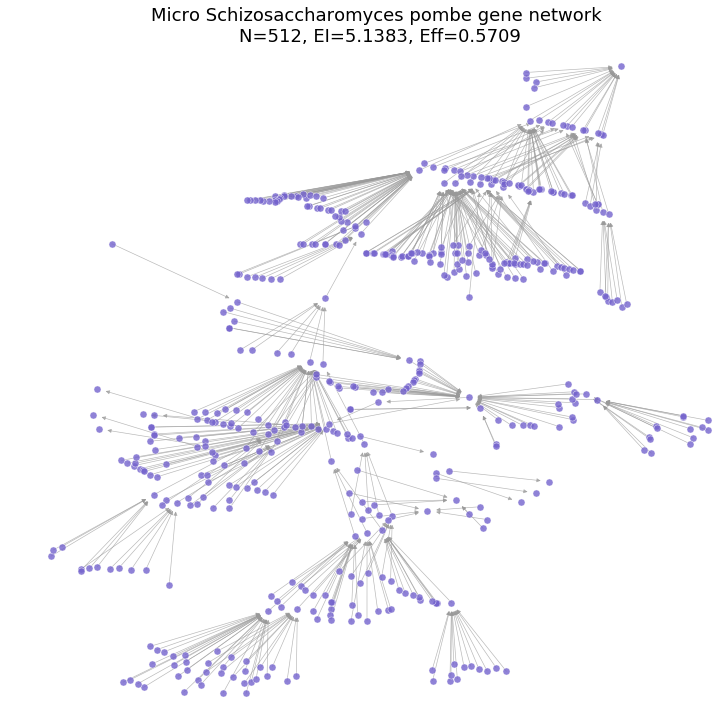

In [21]:
plt.figure(figsize=(12,12))

pos1 = nx.kamada_kawai_layout(GG_sp)
pos = nx.spring_layout(GG_sp, pos=pos1, iterations=5)

nx.draw_networkx_nodes(GG_sp, pos, node_color=nc, node_size=50, edgecolors='w', linewidths=0.5, alpha=0.8)
nx.draw_networkx_edges(GG_sp, pos, edge_color='#999999', width=0.65, alpha=0.7, arrowsize=8)

plt.axis('off')
plt.title("Micro %s \nN=%i, EI=%.4f, Eff=%.4f"%(G_sp_name, GG_sp.number_of_nodes(),
                                    get_ei(GG_sp, p0=0), 
                                    get_ei(GG_sp, p0=0)/np.log2(GG_sp.number_of_nodes())), size=18)

plt.xlim(min(list(zip(*list(pos.values())))[0])-0.01, max(list(zip(*list(pos.values())))[0])+0.01)
plt.ylim(min(list(zip(*list(pos.values())))[1])-0.02, max(list(zip(*list(pos.values())))[1])+0.06)

# plt.savefig("../figs/pngs/S_pombe_micro_network.png", dpi=425, bbox_inches='tight')#, facecolor='#262626')
# plt.savefig("../figs/pdfs/S_pombe_micro_network.pdf", bbox_inches='tight')#, facecolor='#262626')
pos_micro = pos
micro_pos = pos

plt.show()

In [312]:
p0=0
mG, mapping, GG = causal_emergence(GG, p0)

Starting with this tpm:
 [[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]

Search started... current_ei = 5.4822
001 ... 193 ... macro size = 256
002 ... 35 ... macro size = 256
003 ... 75 ... macro size = 256
just found successful macro grouping... current_ei = 5.4856
just found successful macro grouping... current_ei = 5.4885
just found successful macro grouping... current_ei = 5.4935
just found successful macro grouping... current_ei = 5.5017
just found successful macro grouping... current_ei = 5.5046
just found successful macro grouping... current_ei = 5.5135
just found successful macro grouping... current_ei = 5.5156
just found successful macro grouping... current_ei = 5.5247
just found successful macro grouping... current_ei = 5.5341
just found successful macro grouping... current_ei = 5.5434
just found successful macro grouping...

just found successful macro grouping... current_ei = 5.8549
just found successful macro grouping... current_ei = 5.8589
073 ... 59 ... macro size = 164
just found successful macro grouping... current_ei = 5.8591
just found successful macro grouping... current_ei = 5.8593
just found successful macro grouping... current_ei = 5.8598
just found successful macro grouping... current_ei = 5.8606
074 ... 120 ... macro size = 164
just found successful macro grouping... current_ei = 5.8625
just found successful macro grouping... current_ei = 5.8638
075 ... 54 ... macro size = 162
076 ... 99 ... macro size = 162
077 ... 168 ... macro size = 162
078 ... 113 ... macro size = 162
just found successful macro grouping... current_ei = 5.8660
079 ... 195 ... macro size = 161
080 ... 159 ... macro size = 161
081 ... 242 ... macro size = 161
082 ... 9 ... macro size = 161
083 ... 58 ... macro size = 161
just found successful macro grouping... current_ei = 5.8681
084 ... 123 ... macro size = 160
085 ... 50

In [315]:
ss = list(neet_graph.state_space())
mw = get_macro_weights(neet_graph, mapping)
print("Micro sensitivity c elegans:",ns.average_sensitivity(neet_graph))
print("Macro sensitivity c elegans:",ns.average_sensitivity(neet_graph, states=ss, weights=list(mw.values())))
print("Micro effectiveness c elegans:",get_ei(GG, p0)/np.log2(GG.number_of_nodes()))
print("Macro effectiveness c elegans:",get_ei(mG, p0)/np.log2(mG.number_of_nodes()))

Micro sensitivity c elegans: 1.265625
Macro sensitivity c elegans: 1.31881864955
Micro effectiveness c elegans: 0.685271863897
Macro effectiveness c elegans: 0.807362508748


In [24]:
def get_macro_weights(NeetGraph, mapping):
    """Returns a weighting after causal emergence for neet."""
    ss = list(NeetGraph.state_space())
    microstate_mapping = dict(zip(list(range(len(ss))), ss))
    microstate_weights = []
    for micro_num, micro_state in microstate_mapping.items():
        if micro_num in list(mapping.keys()):
            macros = mapping[micro_num]
            other_micros_leading_to_macro = [microstate_mapping[i] for i in microstate_mapping.keys() \
                                             if mapping[i]==macros]
            microstate_weights.append(1/len(other_micros_leading_to_macro))
        else:
            microstate_weights.append(1)

    return dict(zip(list(range(len(ss))), microstate_weights))  

In [272]:
macro_cols = []
macro_pos  = {}
for micro, macro in mapping.items():
    if micro==macro:
        macro_cols.append(colors[1])
        macro_pos[micro] = micro_pos[micro] 
    else:
        macro_cols.append(colors[2])
        micros_for_macro_pos = np.array([micro_pos[i] for i in micro_pos.keys() if mapping[i]==macro])
        macro_pos[macro] = np.average(micros_for_macro_pos, axis=0)

In [280]:
plt.figure(figsize=(12,12))

pos = macro_pos
sizes = [75 if i!=macro_cols[-1] else 50 for i in macro_cols]
mG = nx.relabel_nodes(mG, dict(zip(list(mG.nodes()), list(macro_pos.keys()))))
fixnodes = list(set([i for i in list(pos.keys()) if i in list(micro_pos.keys())]))
pos = nx.spring_layout(mG, pos=pos, fixed=fixnodes, iterations=3)

nx.draw_networkx_nodes(mG, pos, node_color=macro_cols, node_size=sizes, edgecolors='w', linewidths=0.5, alpha=0.8)
nx.draw_networkx_edges(mG, pos, edge_color='#999999', width=0.6, alpha=0.7, arrowsize=7)

plt.axis('off')
plt.title("Macro %s \nN=%i, EI=%.4f, Eff=%.4f"%(Gname, mG.number_of_nodes(),
                                    get_ei(mG, p0=0), 
                                    get_ei(mG, p0=0)/np.log2(mG.number_of_nodes())), size=18)

plt.xlim(min(list(zip(*list(pos.values())))[0])-0.02, max(list(zip(*list(pos.values())))[0])+0.06)
plt.ylim(min(list(zip(*list(pos.values())))[1])-0.02, max(list(zip(*list(pos.values())))[1])+0.06)

# plt.savefig("../figs/pngs/S_pombe_macro_network.png", dpi=425, bbox_inches='tight')#, facecolor='#262626')
# plt.savefig("../figs/pdfs/S_pombe_macro_network.pdf", bbox_inches='tight')#, facecolor='#262626')

plt.show()

In [166]:
mG2 = mG.copy()
G6 = nx.DiGraph()
new_add = mG.copy()
H = s[0].copy()
H = nx.compose(H, s[2])
H = nx.compose(H, s[3])
H = nx.compose(H, s[4])
H = nx.compose(H, s[5])
H = nx.compose(H, s[6])
maxHind = max(list(H.nodes()))
new_add = nx.relabel_nodes(new_add, dict(zip(list(new_add.nodes()), [i+maxHind for i in list(new_add.nodes())])))
H = nx.compose(H, new_add)
print(get_ei(neet.synchronous.transition_graph(s_cerevisiae), p0=p0))
print(get_ei(H,p0))

plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(H)
nx.draw_networkx_nodes(H, pos, node_size=50, 
                       linewidths=1.5, node_color='dodgerblue').set_edgecolor('w')
nx.draw_networkx_edges(H, pos, edge_color='grey', width=1.0)
plt.axis('off')
plt.show()

In [180]:
plt.figure(figsize=(10,10))
plt.imshow(nx.to_numpy_array(G), cmap=plt.cm.Greys_r)
plt.grid()
plt.show()

NameError: name 'G' is not defined

<Figure size 720x720 with 0 Axes>

In [48]:
# np.save("../data/myelin.npy", myelin_mapping)

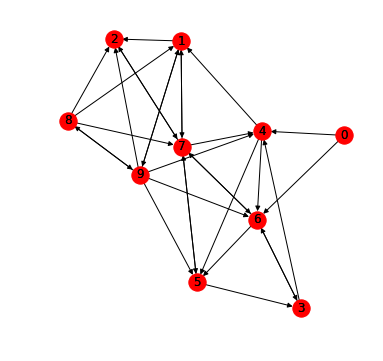

Adjacency:	 0.5359375
Boolean:	 1.01875


In [31]:
# Apoptosis Network
tlg = nn.LogicNetwork.read_logic('../data/walker/logic/mammalian_expressions.ALL.txt', 
             external_nodes_path='../data/walker/logic/mammalian_external_components.ALL.txt')
tlG = nn.LogicNetwork.to_networkx_graph(tlg)
plt.figure(figsize=(6,6))
pos = nx.kamada_kawai_layout(tlG)
nx.draw_networkx(tlG, pos)
nx.draw_networkx_labels(tlG, pos)
plt.axis('off')
plt.show()

xx = nn.LogicNetwork.to_networkx_graph(tlg, 'names')

print("Adjacency:\t",ns.average_sensitivity(nn.WTNetwork(nx.to_numpy_array(tlG))))
print("Boolean:\t",ns.average_sensitivity(tlg))

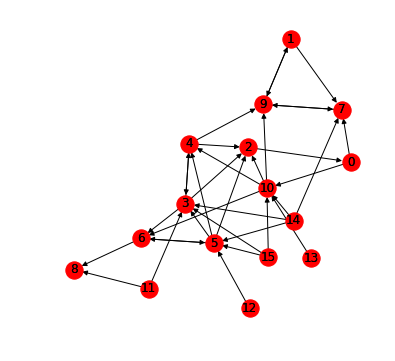

Adjacency:	 0.69921875
Boolean:	 0.78515625


In [30]:
# Breast cell 
tlg = nn.LogicNetwork.read_logic('../data/walker/logic/breastcell_expressions.ALL.txt', 
             external_nodes_path='../data/walker/logic/breastcell_external_components.ALL.txt')
tlG = nn.LogicNetwork.to_networkx_graph(tlg)
plt.figure(figsize=(6,6))
pos = nx.kamada_kawai_layout(tlG)
nx.draw_networkx(tlG, pos)
nx.draw_networkx_labels(tlG, pos)
plt.axis('off')
plt.show()

xx = nn.LogicNetwork.to_networkx_graph(tlg, 'names')

print("Adjacency:\t",ns.average_sensitivity(nn.WTNetwork(nx.to_numpy_array(tlG))))
print("Boolean:\t",ns.average_sensitivity(tlg))

In [27]:
# Drosophila signaling pathway
tlg = nn.LogicNetwork.read_logic('../data/walker/logic/drosophila_expressions.ALL.txt', 
             external_nodes_path='../data/walker/logic/drosophila_external_components.ALL.txt')
tlG = nn.LogicNetwork.to_networkx_graph(tlg)
plt.figure(figsize=(8,8))
pos = nx.kamada_kawai_layout(tlG)
nx.draw_networkx(tlG, pos)
nx.draw_networkx_labels(tlG, pos)
plt.axis('off')
plt.show()

xx = nn.LogicNetwork.to_networkx_graph(tlg, 'names')

print("Adjacency:\t",ns.average_sensitivity(nn.WTNetwork(nx.to_numpy_array(tlG))))
print("Boolean:\t",ns.average_sensitivity(tlg))

Adjacency:	 0.977272727273
Boolean:	 1.0


In [32]:
# Metabolic Gut Microbiome
tlg = nn.LogicNetwork.read_logic('../data/walker/logic/gut_expressions.ALL.txt', 
             external_nodes_path='../data/walker/logic/gut_external_components.ALL.txt')
tlG = nn.LogicNetwork.to_networkx_graph(tlg)
plt.figure(figsize=(6,6))
pos = nx.kamada_kawai_layout(tlG)
nx.draw_networkx(tlG, pos)
nx.draw_networkx_labels(tlG, pos)
plt.axis('off')
plt.show()

xx = nn.LogicNetwork.to_networkx_graph(tlg, 'names')

print("Adjacency:\t",ns.average_sensitivity(nn.WTNetwork(nx.to_numpy_array(tlG))))
print("Boolean:\t",ns.average_sensitivity(tlg))

Adjacency:	 0.776041666667
Boolean:	 1.00520833333


In [34]:
# Lac Operon
tlg = nn.LogicNetwork.read_logic('../data/walker/logic/lac_expressions.ALL.txt', 
             external_nodes_path='../data/walker/logic/lac_external_components.ALL.txt')
tlG = nn.LogicNetwork.to_networkx_graph(tlg)
plt.figure(figsize=(6,6))
pos = nx.kamada_kawai_layout(tlG)
nx.draw_networkx(tlG, pos)
nx.draw_networkx_labels(tlG, pos)
plt.axis('off')
plt.show()

xx = nn.LogicNetwork.to_networkx_graph(tlg, 'names')

print("Adjacency:\t",ns.average_sensitivity(nn.WTNetwork(nx.to_numpy_array(tlG))))
print("Boolean:\t",ns.average_sensitivity(tlg))

Adjacency:	 0.826923076923
Boolean:	 1.0


In [35]:
# E-colo
tlg = nn.LogicNetwork.read_logic('../data/walker/logic/ecoli_expressions.ALL.txt', 
             external_nodes_path='../data/walker/logic/ecoli_external_components.ALL.txt')
tlG = nn.LogicNetwork.to_networkx_graph(tlg)
plt.figure(figsize=(6,6))
pos = nx.kamada_kawai_layout(tlG)
nx.draw_networkx(tlG, pos)
nx.draw_networkx_labels(tlG, pos)
plt.axis('off')
plt.show()

xx = nn.LogicNetwork.to_networkx_graph(tlg, 'names')

print("Adjacency:\t",ns.average_sensitivity(nn.WTNetwork(nx.to_numpy_array(tlG))))
print("Boolean:\t",ns.average_sensitivity(tlg))

Adjacency:	 0.884615384615
Boolean:	 1.03846153846


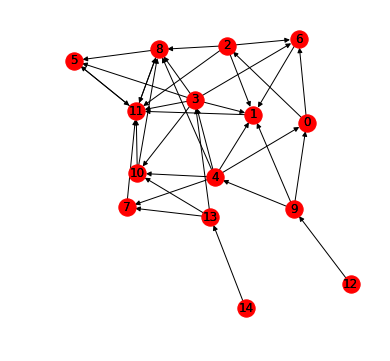

Adjacency:	 0.702083333333
Boolean:	 0.990625


In [36]:
# cardiac development
tlg = nn.LogicNetwork.read_logic('../data/walker/logic/cardiac_expressions.ALL.txt', 
             external_nodes_path='../data/walker/logic/cardiac_external_components.ALL.txt')
tlG = nn.LogicNetwork.to_networkx_graph(tlg)
plt.figure(figsize=(6,6))
pos = nx.kamada_kawai_layout(tlG)
nx.draw_networkx(tlG, pos)
nx.draw_networkx_labels(tlG, pos)
plt.axis('off')
plt.show()

xx = nn.LogicNetwork.to_networkx_graph(tlg, 'names')

print("Adjacency:\t",ns.average_sensitivity(nn.WTNetwork(nx.to_numpy_array(tlG))))
print("Boolean:\t",ns.average_sensitivity(tlg))

_________________________

In [1125]:
# konect_data = np.load('../data/konect_data/konect_data_best.npy').item()
labs = ["citations", "coauthorship", "communication", "computer", "connectomic", "humancontact", "humansocial", 
        "hyperlink", "infrastructure", "lexical", "metabolic", "social", "software", "trophic"]

cols = ["#ba4b57","#cc5134","#daaa32","#b8ab51","#698b4a","#69d07d","#50c9b5",
        "#64b6ff","#786bdb","#573689","#c65abb","#b55083","#bfbfbf","#666666"]
# np.random.shuffle(cols)
col_mapping = dict(zip(labs, cols))

# konect_data['color'] = [col_mapping[i] for i in konect_data['types']]
# konect_data['num'] = np.array(list(range(len(konect_data['effec']))))
# konect_data['names'][5] = 'High Energy Physics - Ph. Coauthors'
# konect_data['names'][6] = 'High Energy Physics - Th. Coauthors'

# newty = ["information","information","social","technological","biological","social","social","information",
#          "technological","information","biological","social","information","biological"]
# newty = dict(zip(list(np.unique(konect_data['types'])), newty))

# konect_data['newty'] = [newty[i] for i in konect_data['types']]

# newco = ["#c34b57","#c6b950","#865db4","#64b9b0"]
# newco = dict(zip(list(np.unique(konect_data['newty'])), newco))

# konect_data['newco'] = [newco[i] for i in konect_data['newty']]

In [40]:
konect_data_new = konect_data.copy()

In [42]:
names = list(konect_data_new.keys())
konect_data_small = {}
for i in names:
    konect_data_small[i] = []
    for net in range(len(konect_data_new['nodes'])):
        if konect_data_new['nodes'][net] < 2000:
            konect_data_small[i].append(konect_data_new[i][net])
            
df_konect_ce = pd.DataFrame(konect_data_small)            
df_konect_ce.head()

names          types  nodes  edges     effin  \
0              Tarragona Emails  communication   1133   5451  7.404319   
1                    DNC Emails  communication   1891   5598  5.119516   
2            UC Irvine Messages  communication   1899  20295  6.892297   
3  Manufacturing Company Emails  communication    167   5784  2.412427   
4                  RFID Contact   humancontact    274   2899  0.817207   

      effec      deter     degen    color  num   newty    newco  
0  0.729782   8.046307  0.641991  #daaa32    7  social  #865db4  
1  0.470331  10.000852  4.881334  #daaa32    8  social  #865db4  
2  0.632842   8.172760  1.280462  #daaa32   11  social  #865db4  
3  0.326723   3.107276  0.694847  #daaa32   12  social  #865db4  
4  0.100914   1.985445  1.168238  #69d07d   16  social  #865db4

In [44]:
new_names

['Arabadopsis Interactions',
 'Cat Brain',
 'Drosophila Medulla',
 'Kasthuri Mouse Brains',
 'Mouse Brain',
 'Mouse Retina',
 'Rattus Norvegicus Rat Brain',
 'Rhesus Brain 1',
 'Rhesus Brain 2',
 'Rhesus Cerebral Cortex',
 'Rhesus Interareal Cortical Network']

In [109]:
G_cb = nx.DiGraph(nx.read_graphml("../data/icon_data/cat_mixedspecies_brain_1.graphml"))
G_dr = nx.DiGraph(nx.read_graphml("../data/icon_data/drosophila_medulla_1.graphml"))
G_ka = nx.DiGraph(nx.read_graphml("../data/icon_data/kasthuri_graph_v4.graphml"))
G_mb = nx.DiGraph(nx.read_graphml("../data/icon_data/mouse_brain_1.graphml"))
G_mr = nx.DiGraph(nx.read_graphml("../data/icon_data/mouse_retina_1.graphml"))
G_ra = nx.DiGraph(nx.read_graphml("../data/icon_data/rattus.norvegicus_brain_1.graphml"))
G_r1 = nx.DiGraph(nx.read_graphml("../data/icon_data/rhesus_brain_1.graphml"))
G_r2 = nx.DiGraph(nx.read_graphml("../data/icon_data/rhesus_brain_2.graphml"))
G_rc = nx.DiGraph(nx.read_graphml("../data/icon_data/rhesus_cerebral.cortex_1.graphml"))
G_ri = nx.DiGraph(nx.read_graphml("../data/icon_data/rhesus_interareal.cortical.network_2.graphml"))
G_wi = nx.read_edgelist("../data/icon_data/wikipedia_norms_edgelist.csv", delimiter=',', create_using=nx.DiGraph())
# ## print("Done")

In [110]:
[i.is_multigraph() for i in new_netws]

[False, True, True, False, True, False, False, False, True, False, False]

In [111]:
p0 = 0.0

In [172]:
new_names = ['Cat Brain', 
             'Drosophila Medulla', 
             "Kasthuri Mouse Brains", 
             "Mouse Brain", 
             "Mouse Retina", 
             "Rattus Norvegicus Brain", 
             "Rhesus Brain 1", 
             "Rhesus Brain 2", 
             "Rhesus Cerebral Cortex", 
             "Rhesus Interareal Cortical Network", 
             "Wikipedia Norms"]#, 'Arabadopsis Interactions']
new_types = ["connectomic", 
             "connectomic", 
             "connectomic", 
             "connectomic", 
             "connectomic", 
             "connectomic", 
             "connectomic", 
             "connectomic", 
             "connectomic", 
             "connectomic", 
             "hyperlink"]#,'metabolic']

new_netws = [G_cb, G_dr, G_ka, G_mb, G_mr, G_ra, G_r1, G_r2, G_rc, G_ri, G_wi]
new_nodes = [i.number_of_nodes() for i in new_netws]
new_edges = [i.number_of_edges() for i in new_netws]
new_effin = [get_ei(nx.to_directed(i), p0)       for i in new_netws]
new_effec = [new_effin[i]/np.log2(new_nodes[i]) for i in range(len(new_netws))]
new_deter = [get_determinism(i, p0) for i in new_netws]
new_degen = [get_degeneracy(i, p0) for i in new_netws]
new_color = ["#698b4a", "#698b4a", "#698b4a", "#698b4a", "#698b4a", 
            "#698b4a", "#698b4a", "#698b4a", "#698b4a", "#698b4a", "#64b6ff"]
new_num = [max(konect_data['num'])+i for i in range(len(new_netws))]
new_newty = ["biological", "biological", "biological", "biological", 
             "biological", "biological", "biological", "biological", 
             "biological", "biological", "information"]
new_newco = ["#c34b57", "#c34b57", "#c34b57", "#c34b57", "#c34b57", 
            "#c34b57", "#c34b57", "#c34b57", "#c34b57", "#c34b57", "#c6b950"]

new_dict = {'names':new_names, 
            'types':new_types, 
            'nodes':new_nodes, 
            'edges':new_edges, 
            'effin':new_effin, 
            'effec':new_effec, 
            'deter':new_deter, 
            'degen':new_degen, 
            'color':new_color, 
            'num':new_num, 
            'newty':new_newty, 
            'newco':new_newco}

In [173]:
konect_data = {}
ds = [new_dict, konect_data_small]
for k in list(new_dict.keys()):
    konect_data[k] = list(ds[0][k]) + ds[1][k]

In [174]:
len(konect_data['effin'])

47

In [232]:
len(konect_data_small['names'])

36

In [176]:
len(id_order)

47

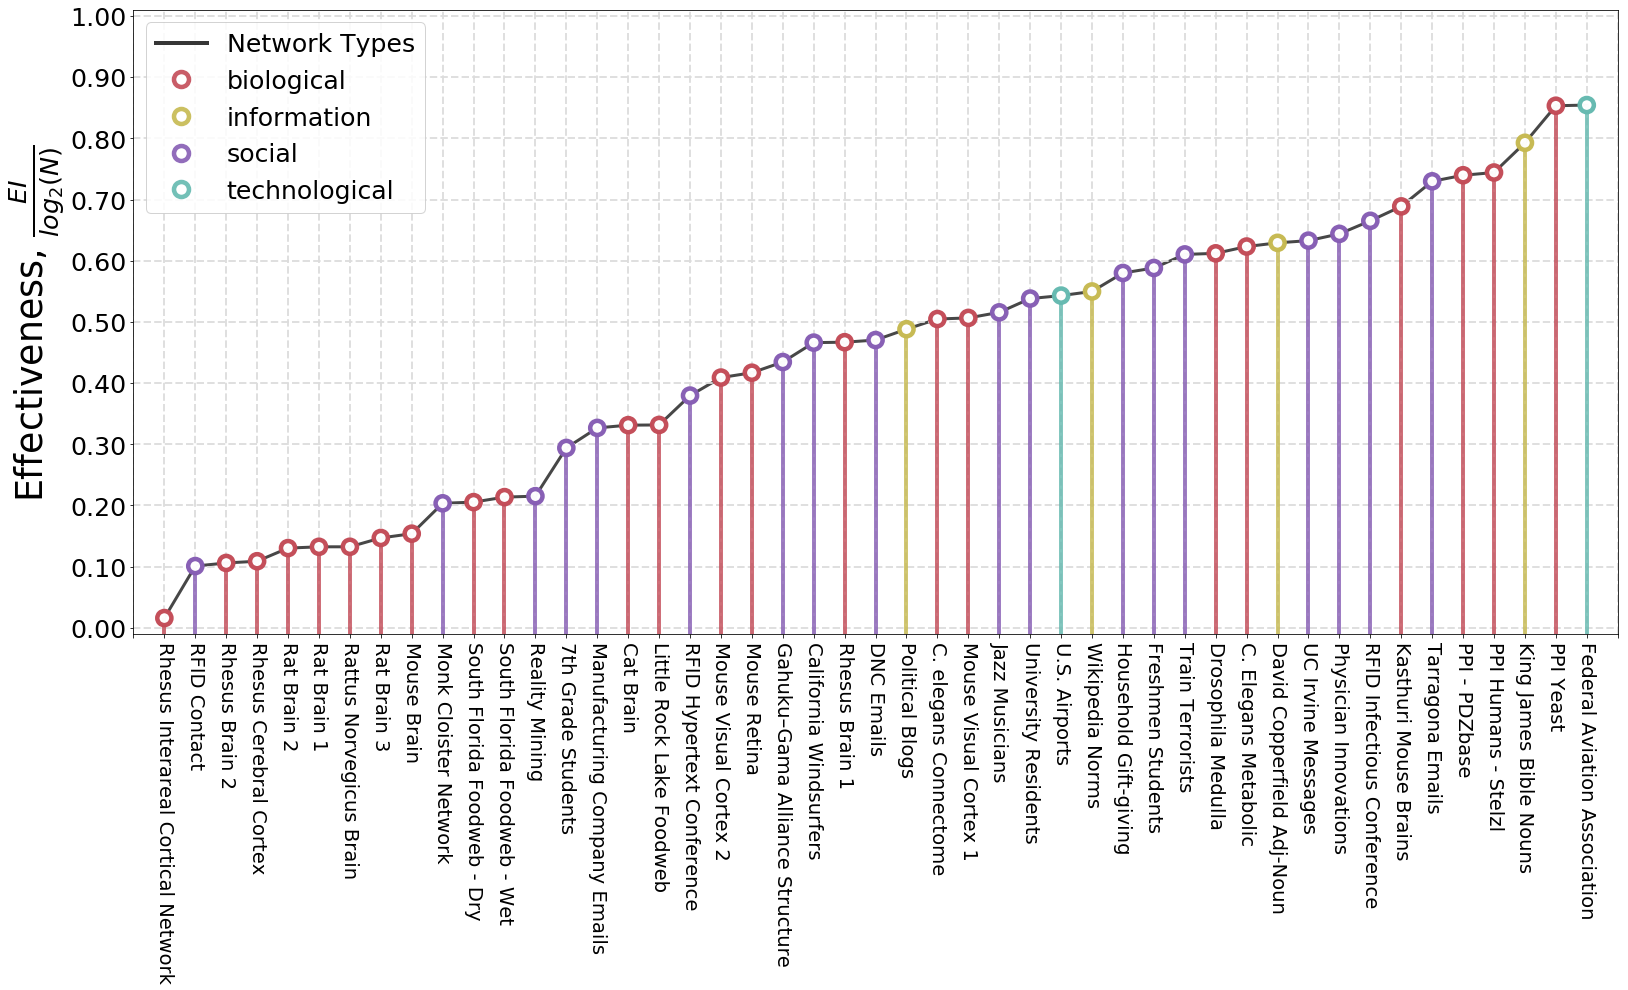

In [187]:
plt.rc('axes', axisbelow=True)

id_order = np.argsort(konect_data['effec'])
colors = np.array(konect_data['newco'])[id_order]
mult = 1.4

plt.figure(figsize=(19*mult,8.2*mult))

plt.plot([-10],[-10], marker='', 
         markersize=18, alpha=0.99, linestyle='-', linewidth=4.0,
         markeredgecolor='#333333', color='#333333', markeredgewidth=5.5, 
         markerfacecolor="w", label='Network Types')

plt.vlines(sorted(id_order),-1,np.array(konect_data['effec'])[id_order], colors=colors, 
           linewidth=4.0, alpha=0.8, zorder=1)

plt.plot(sorted(id_order), np.array(konect_data['effec'])[id_order], alpha=0.9,
         marker='', linestyle='-', linewidth=3.0, color='#333333', zorder=0)

plt.scatter(sorted(id_order), np.array(konect_data['effec'])[id_order], 
            marker='o', s=200, alpha=0.98,
            edgecolors=colors, linewidths=4.5, facecolor="w")

for types, color in newco.items():
    plt.plot([-10],[-10], marker='o', 
         markersize=15, alpha=0.9, linestyle='', linewidth=3.0,
         markeredgecolor=color, markeredgewidth=4.5, 
         markerfacecolor="w", label=types)

xtix = np.linspace(-1,len(konect_data['names']),len(konect_data['names'])+2)
xticklist = [""]
for i in range(len(konect_data['names'])):
    xticklist.append(np.array(konect_data['names'])[id_order][i])
xticklist.append("")

plt.xticks(xtix, xticklist, rotation=270, size=14*mult)
plt.yticks(np.linspace(0,1,11), ["%.2f"%i for i in np.linspace(0,1,11)], size=18*mult)
plt.grid(alpha=0.9, color='gainsboro', linestyle='--', linewidth=2.0)
plt.xlim(-1,len(konect_data['names']))
plt.ylim(-0.01,1.01)
plt.ylabel(r'Effectiveness, $\frac{EI}{log_2(N)}$', size=26*mult)
plt.legend(loc=2, fontsize=18*mult, framealpha=0.85)

# plt.savefig("../figs/pngs/Konect_SortedEffectiveness_4col.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Konect_SortedEffectiveness_4col.pdf", bbox_inches='tight')
plt.show()

In [191]:
len(konect_data_new['effin'])

65

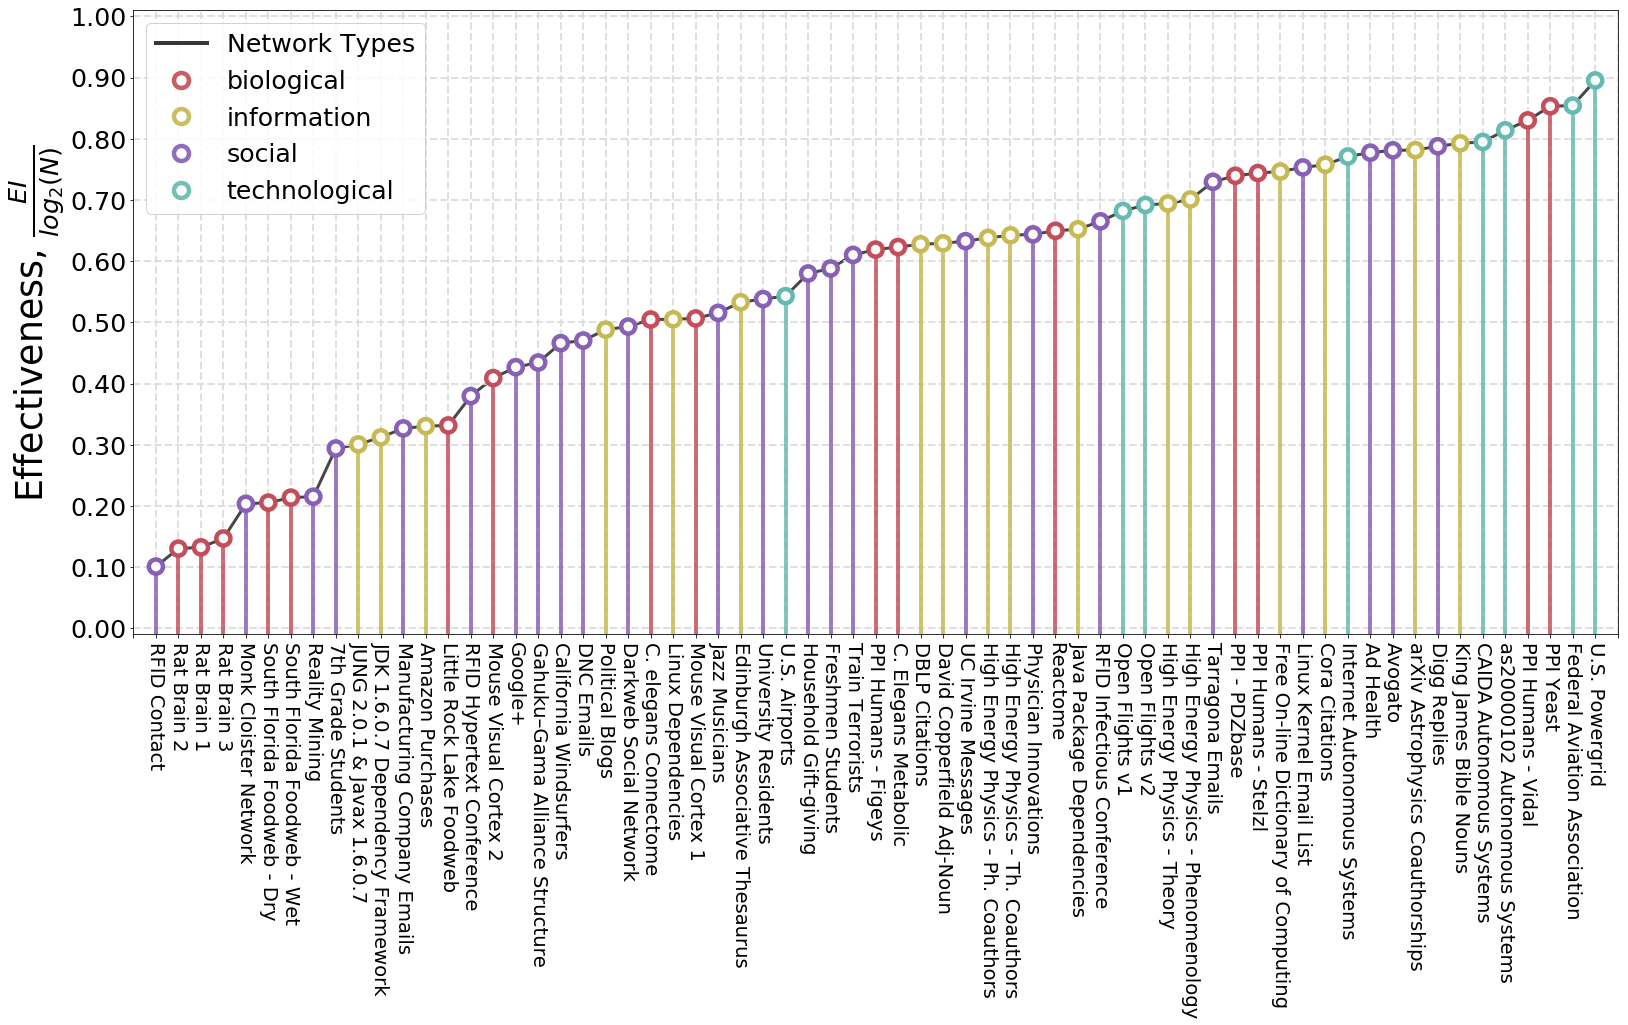

In [192]:
plt.rc('axes', axisbelow=True)

id_order = np.argsort(konect_data_new['effec'])
colors = np.array(konect_data_new['newco'])[id_order]
mult = 1.4

plt.figure(figsize=(19*mult,8.2*mult))

plt.plot([-10],[-10], marker='', 
         markersize=18, alpha=0.99, linestyle='-', linewidth=4.0,
         markeredgecolor='#333333', color='#333333', markeredgewidth=5.5, 
         markerfacecolor="w", label='Network Types')

plt.vlines(sorted(id_order),-1,np.array(konect_data_new['effec'])[id_order], colors=colors, 
           linewidth=4.0, alpha=0.8, zorder=1)

plt.plot(sorted(id_order), np.array(konect_data_new['effec'])[id_order], alpha=0.9,
         marker='', linestyle='-', linewidth=3.0, color='#333333', zorder=0)

plt.scatter(sorted(id_order), np.array(konect_data_new['effec'])[id_order], 
            marker='o', s=200, alpha=0.98,
            edgecolors=colors, linewidths=4.5, facecolor="w")

for types, color in newco.items():
    plt.plot([-10],[-10], marker='o', 
         markersize=15, alpha=0.9, linestyle='', linewidth=3.0,
         markeredgecolor=color, markeredgewidth=4.5, 
         markerfacecolor="w", label=types)

xtix = np.linspace(-1,len(konect_data_new['names']),len(konect_data_new['names'])+2)
xticklist = [""]
for i in range(len(konect_data_new['names'])):
    xticklist.append(np.array(konect_data_new['names'])[id_order][i])
xticklist.append("")

plt.xticks(xtix, xticklist, rotation=270, size=14*mult)
plt.yticks(np.linspace(0,1,11), ["%.2f"%i for i in np.linspace(0,1,11)], size=18*mult)
plt.grid(alpha=0.9, color='gainsboro', linestyle='--', linewidth=2.0)
plt.xlim(-1,len(konect_data_new['names']))
plt.ylim(-0.01,1.01)
plt.ylabel(r'Effectiveness, $\frac{EI}{log_2(N)}$', size=26*mult)
plt.legend(loc=2, fontsize=18*mult, framealpha=0.85)

# plt.savefig("../figs/pngs/Konect_SortedEffectiveness_4col.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Konect_SortedEffectiveness_4col.pdf", bbox_inches='tight')
plt.show()

In [200]:
set(list(konect_data_new['names'])) - set(list(konect_data['names']))

{'Ad Health',
 'Amazon Purchases',
 'Avogato',
 'CAIDA Autonomous Systems',
 'Cora Citations',
 'DBLP Citations',
 'Darkweb Social Network',
 'Digg Replies',
 'Edinburgh Associative Thesaurus',
 'Free On-line Dictionary of Computing',
 'Google+',
 'High Energy Physics - Ph. Coauthors',
 'High Energy Physics - Phenomenology',
 'High Energy Physics - Th. Coauthors',
 'High Energy Physics - Theory',
 'Internet Autonomous Systems',
 'JDK 1.6.0.7 Dependency Framework',
 'JUNG 2.0.1 & Javax 1.6.0.7',
 'Java Package Dependencies',
 'Linux Dependencies',
 'Linux Kernel Email List',
 'Open Flights v1',
 'Open Flights v2',
 'PPI Humans - Figeys',
 'PPI Humans - Vidal',
 'Reactome',
 'U.S. Powergrid',
 'arXiv Astrophysics Coauthorships',
 'as20000102 Autonomous Systems'}

In [210]:
test_dict = {}
test_dict.update(konect_data)
test1_dd = test_dict.copy()
test1_dd.update(konect_data_new)


In [1163]:
real_networks[real_networks['num']==70]

color     degen    deter  edges     effec     effin  \
70  #698b4a  2.572645  3.76093  27667  0.132408  1.188286   

                      names    newco       newty  nodes  num        types  
70  Rattus Norvegicus Brain  #c34b57  biological    503   70  connectomic

In [1166]:
x = 1; y = 2

In [1165]:
# real_networks = pd.DataFrame(konect_data_new)
# real_networks = real_networks.append(pd.DataFrame(konect_data)[0:11])
real_networks.drop([70], axis=0)
real_networks

color     degen      deter    edges     effec      effin  \
0   #ba4b57  1.479658  12.047861   421578  0.700984  10.568201   
1   #ba4b57  1.455544  11.705607   352807  0.694390  10.250063   
2   #ba4b57  1.883286  12.870240    91500  0.757736  10.986954   
3   #ba4b57  1.522936  10.073271    49743  0.627773   8.550336   
4   #cc5134  0.532844  11.628862   198050  0.781618  11.096018   
5   #cc5134  0.448587   9.879379  3148446  0.638168   9.430793   
6   #cc5134  0.481601   9.787133  2444797  0.642489   9.305532   
7   #daaa32  0.641991   8.046307     5451  0.729782   7.404319   
8   #daaa32  4.881334  10.000852     5598  0.470331   5.119516   
9   #daaa32  2.308754  13.434429   242976  0.753294  11.125673   
10  #daaa32  2.050018  13.783683    86403  0.787934  11.733665   
11  #daaa32  1.280462   8.172760    20295  0.632842   6.892297   
12  #daaa32  0.694847   3.107276     5784  0.326723   2.412427   
13  #b8ab51  1.836896  13.516881    53381  0.794971  11.679988   
14  #b8ab51  1.402222  11.706783    13895  0.813918  10.304562   
15  #b8ab51  1.682595  13.316146   114495  0.771191  11.633551   
16  #69d07d  1.168238   1.985445     2899  0.100914   0.817207   
17  #69d07d  0.726648   2.143469     2539  0.215160   1.416822   
18  #69d07d  0.632437   3.161656      335  0.466107   2.529218   
19  #69d07d  0.574064   4.235677      242  0.610269   3.661612   
20  #69d07d  0.602395   3.191022     2195  0.379554   2.588627   
21  #69d07d  0.473489   6.247285     2764  0.665224   5.773794   
22  #50c9b5  0.492436   4.426156     2742  0.515603   3.933720   
23  #50c9b5  0.363369   9.156196    12968  0.777435   8.792827   
24  #50c9b5  0.560253   5.655028     1098  0.643858   5.094775   
25  #50c9b5  0.177820   4.354571     2671  0.538134   4.176751   
26  #50c9b5  0.047578   0.896150      188  0.203498   0.848573   
27  #50c9b5  0.101699   1.529843      375  0.293979   1.428143   
28  #50c9b5  0.089844   2.676132       78  0.579960   2.586291   
29  #50c9b5  0.261791   3.202206      709  0.588083   2.940413   
..      ...       ...        ...      ...       ...        ...   
57  #698b4a  0.598252   3.709461      214  0.408975   3.111212   
58  #698b4a  2.572480   3.760474    27667  0.132376   1.187994   
59  #698b4a  2.517726   3.686948    30088  0.130284   1.169224   
60  #698b4a  2.227605   3.542502    33020  0.146847   1.314898   
61  #64b6ff  7.507114  11.304223     3904  0.330432   3.797107   
62  #bfbfbf  2.561498   9.954007     9391  0.652258   7.392510   
63  #b55083  5.568425  11.886464    25104  0.493236   6.318038   
64  #698b4a  0.453011   4.766726     5129  0.504711   4.313712   
65  #698b4a  0.182306   2.177033     1139  0.331220   1.994727   
66  #698b4a  2.346171   8.955563     9735  0.612067   6.609392   
67  #698b4a  2.188561   9.081172     1559  0.688777   6.892611   
68  #698b4a  0.020350   1.210132    21807  0.153824   1.189782   
69  #698b4a  0.860139   5.084893    90811  0.416924   4.224753   
70  #698b4a  2.572645   3.760930    27667  0.132408   1.188286   
71  #698b4a  0.727265   4.423958     4090  0.466821   3.696693   
72  #698b4a  3.194791   3.884462      628  0.105976   0.689671   
73  #698b4a  1.714671   2.422815     1615  0.108815   0.708144   
74  #698b4a  1.691208   1.795208     2667  0.015904   0.104000   
75  #64b6ff  2.312842   8.293239    17236  0.549729   5.980397   
76  #daaa32  5.402307  14.853131   321918  0.575805   9.450823   
77  #666666  3.742080   4.394178      915  0.106752   0.652098   
78  #666666  2.836564   4.230117      355  0.242151   1.393553   
79  #666666  4.065849   5.091686     1491  0.155432   1.025837   
80  #b8ab51  5.224133  14.568694    85123  0.611011   9.344562   
81  #b8ab51  1.606704  12.374252    24316  0.804592  10.767548   
82  #b8ab51  3.301982  11.086741    56943  0.604968   7.784759   
83  #b8ab51  1.715672   9.744736     6632  0.726936   8.029064   
84  #786bdb  0.445390   8.173761     9864  0.757708   7.728370   
85  #786bdb  0.193556   9.834967     4117  0.8

In [1103]:
real_networks_dict = pd.DataFrame.to_dict(real_networks, orient='list')

In [1104]:
real_networks_dict['num'] = list(range(len(real_networks_dict['names'])))

In [1105]:
pd.DataFrame(real_networks_dict)

color     degen      deter    edges     effec      effin  \
0   #ba4b57  1.479658  12.047861   421578  0.700984  10.568201   
1   #ba4b57  1.455544  11.705607   352807  0.694390  10.250063   
2   #ba4b57  1.883286  12.870240    91500  0.757736  10.986954   
3   #ba4b57  1.522936  10.073271    49743  0.627773   8.550336   
4   #cc5134  0.532844  11.628862   198050  0.781618  11.096018   
5   #cc5134  0.448587   9.879379  3148446  0.638168   9.430793   
6   #cc5134  0.481601   9.787133  2444797  0.642489   9.305532   
7   #daaa32  0.641991   8.046307     5451  0.729782   7.404319   
8   #daaa32  4.881334  10.000852     5598  0.470331   5.119516   
9   #daaa32  2.308754  13.434429   242976  0.753294  11.125673   
10  #daaa32  2.050018  13.783683    86403  0.787934  11.733665   
11  #daaa32  1.280462   8.172760    20295  0.632842   6.892297   
12  #daaa32  0.694847   3.107276     5784  0.326723   2.412427   
13  #b8ab51  1.836896  13.516881    53381  0.794971  11.679988   
14  #b8ab51  1.402222  11.706783    13895  0.813918  10.304562   
15  #b8ab51  1.682595  13.316146   114495  0.771191  11.633551   
16  #69d07d  1.168238   1.985445     2899  0.100914   0.817207   
17  #69d07d  0.726648   2.143469     2539  0.215160   1.416822   
18  #69d07d  0.632437   3.161656      335  0.466107   2.529218   
19  #69d07d  0.574064   4.235677      242  0.610269   3.661612   
20  #69d07d  0.602395   3.191022     2195  0.379554   2.588627   
21  #69d07d  0.473489   6.247285     2764  0.665224   5.773794   
22  #50c9b5  0.492436   4.426156     2742  0.515603   3.933720   
23  #50c9b5  0.363369   9.156196    12968  0.777435   8.792827   
24  #50c9b5  0.560253   5.655028     1098  0.643858   5.094775   
25  #50c9b5  0.177820   4.354571     2671  0.538134   4.176751   
26  #50c9b5  0.047578   0.896150      188  0.203498   0.848573   
27  #50c9b5  0.101699   1.529843      375  0.293979   1.428143   
28  #50c9b5  0.089844   2.676132       78  0.579960   2.586291   
29  #50c9b5  0.261791   3.202206      709  0.588083   2.940413   
..      ...       ...        ...      ...       ...        ...   
57  #698b4a  0.598252   3.709461      214  0.408975   3.111212   
58  #698b4a  2.572480   3.760474    27667  0.132376   1.187994   
59  #698b4a  2.517726   3.686948    30088  0.130284   1.169224   
60  #698b4a  2.227605   3.542502    33020  0.146847   1.314898   
61  #64b6ff  7.507114  11.304223     3904  0.330432   3.797107   
62  #bfbfbf  2.561498   9.954007     9391  0.652258   7.392510   
63  #b55083  5.568425  11.886464    25104  0.493236   6.318038   
64  #698b4a  0.453011   4.766726     5129  0.504711   4.313712   
65  #698b4a  0.182306   2.177033     1139  0.331220   1.994727   
66  #698b4a  2.346171   8.955563     9735  0.612067   6.609392   
67  #698b4a  2.188561   9.081172     1559  0.688777   6.892611   
68  #698b4a  0.020350   1.210132    21807  0.153824   1.189782   
69  #698b4a  0.860139   5.084893    90811  0.416924   4.224753   
70  #698b4a  2.572645   3.760930    27667  0.132408   1.188286   
71  #698b4a  0.727265   4.423958     4090  0.466821   3.696693   
72  #698b4a  3.194791   3.884462      628  0.105976   0.689671   
73  #698b4a  1.714671   2.422815     1615  0.108815   0.708144   
74  #698b4a  1.691208   1.795208     2667  0.015904   0.104000   
75  #64b6ff  2.312842   8.293239    17236  0.549729   5.980397   
76  #daaa32  5.402307  14.853131   321918  0.575805   9.450823   
77  #666666  3.742080   4.394178      915  0.106752   0.652098   
78  #666666  2.836564   4.230117      355  0.242151   1.393553   
79  #666666  4.065849   5.091686     1491  0.155432   1.025837   
80  #b8ab51  5.224133  14.568694    85123  0.611011   9.344562   
81  #b8ab51  1.606704  12.374252    24316  0.804592  10.767548   
82  #b8ab51  3.301982  11.086741    56943  0.604968   7.784759   
83  #b8ab51  1.715672   9.744736     6632  0.726936   8.029064   
84  #786bdb  0.445390   8.173761     9864  0.757708   7.728370   
85  #786bdb  0.193556   9.834967     4117  0.8

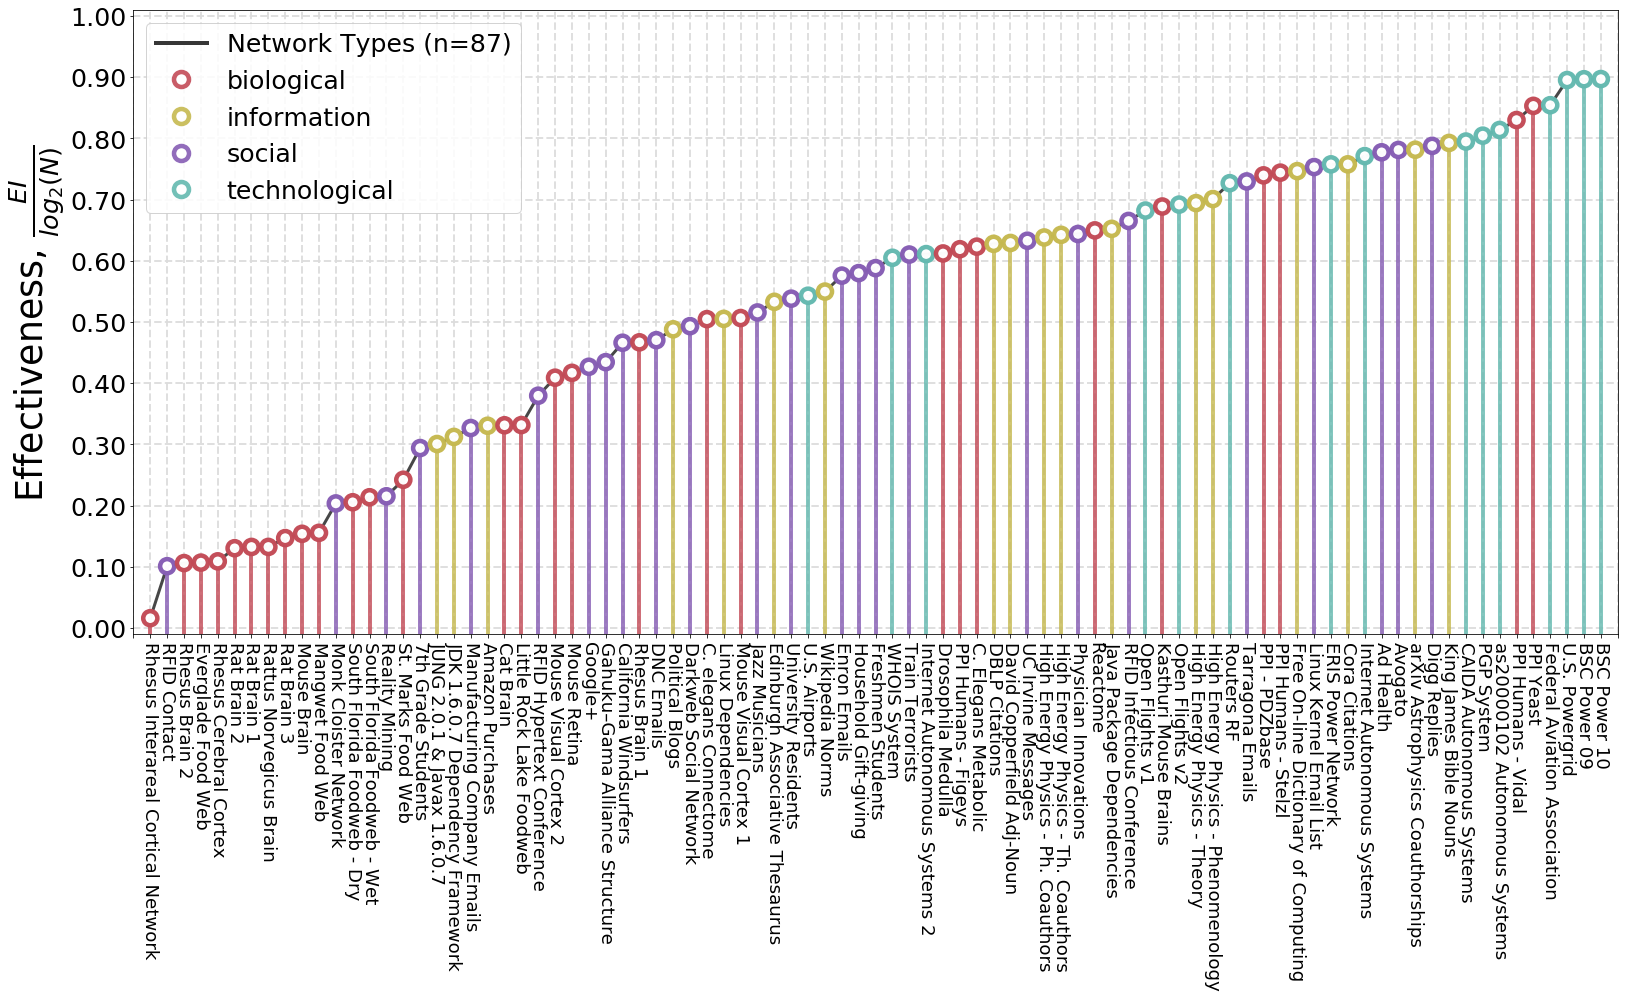

In [1108]:
konect_data_new = real_networks_dict
plt.rc('axes', axisbelow=True)

id_order = np.argsort(konect_data_new['effec'])
colors = np.array(konect_data_new['newco'])[id_order]
mult = 1.4

plt.figure(figsize=(19*mult,8.2*mult))

plt.plot([-10],[-10], marker='', 
         markersize=18, alpha=0.99, linestyle='-', linewidth=4.0,
         markeredgecolor='#333333', color='#333333', markeredgewidth=5.5, 
         markerfacecolor="w", label='Network Types (n=%i)'%len(konect_data_new['names']))

plt.vlines(sorted(id_order),-1,np.array(konect_data_new['effec'])[id_order], colors=colors, 
           linewidth=4.0, alpha=0.8, zorder=1)

plt.plot(sorted(id_order), np.array(konect_data_new['effec'])[id_order], alpha=0.9,
         marker='', linestyle='-', linewidth=3.0, color='#333333', zorder=0)

plt.scatter(sorted(id_order), np.array(konect_data_new['effec'])[id_order], 
            marker='o', s=200, alpha=0.98,
            edgecolors=colors, linewidths=4.5, facecolor="w")

for types, color in newco.items():
    plt.plot([-10],[-10], marker='o', 
         markersize=15, alpha=0.9, linestyle='', linewidth=3.0,
         markeredgecolor=color, markeredgewidth=4.5, 
         markerfacecolor="w", label=types)

xtix = np.linspace(-1,len(konect_data_new['names']),len(konect_data_new['names'])+2)
xticklist = [""]
for i in range(len(konect_data_new['names'])):
    xticklist.append(np.array(konect_data_new['names'])[id_order][i])
xticklist.append("")

plt.xticks(xtix, xticklist, rotation=270, size=13*mult)
plt.yticks(np.linspace(0,1,11), ["%.2f"%i for i in np.linspace(0,1,11)], size=18*mult)
plt.grid(alpha=0.9, color='gainsboro', linestyle='--', linewidth=2.0)
plt.xlim(-1,len(konect_data_new['names']))
plt.ylim(-0.01,1.01)
plt.ylabel(r'Effectiveness, $\frac{EI}{log_2(N)}$', size=26*mult)
plt.legend(loc=2, fontsize=18*mult, framealpha=0.85)

# plt.savefig("../figs/pngs/Konect_SortedEffectiveness_4col0.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Konect_SortedEffectiveness_4col0.pdf", bbox_inches='tight')
plt.show()

In [1131]:
col_mapping = {}
for i in list(zip(konect_data_new['types'],konect_data_new['color'])):
    if i[0] not in col_mapping.keys():
        col_mapping[i[0]] = i[1]
col_mapping

{'citations': '#ba4b57',
 'coauthorship': '#cc5134',
 'communication': '#daaa32',
 'computer': '#b8ab51',
 'connectomic': '#698b4a',
 'humancontact': '#69d07d',
 'humansocial': '#50c9b5',
 'hyperlink': '#64b6ff',
 'infrastructure': '#786bdb',
 'lexical': '#573689',
 'metabolic': '#c65abb',
 'social': '#b55083',
 'software': '#bfbfbf',
 'trophic': '#666666'}

In [1142]:
konect_data_new = real_networks_dict
plt.rc('axes', axisbelow=True)

id_order = np.argsort(konect_data_new['effec'])
colors = np.array(konect_data_new['color'])[id_order]
mult = 1.8

plt.figure(figsize=(16*mult,9*mult))

plt.plot([-10],[-10], marker='', 
         markersize=18, alpha=0.99, linestyle='-', linewidth=4.0,
         markeredgecolor='#333333', color='#333333', markeredgewidth=5.5, 
         markerfacecolor="w", label='Network Types (n=%i)'%len(konect_data_new['names']))

plt.vlines(sorted(id_order),-1,np.array(konect_data_new['effec'])[id_order], colors=colors, 
           linewidth=5.5, alpha=0.8, zorder=1)

plt.plot(sorted(id_order), np.array(konect_data_new['effec'])[id_order], alpha=0.9,
         marker='', linestyle='-', linewidth=3.0, color='#333333', zorder=0)

plt.scatter(sorted(id_order), np.array(konect_data_new['effec'])[id_order], 
            marker='o', s=200, alpha=0.98,
            edgecolors=colors, linewidths=4.5, facecolor="w")

for types, color in col_mapping.items():
    plt.plot([-10],[-10], marker='o', 
         markersize=15, alpha=0.9, linestyle='', linewidth=3.0,
         markeredgecolor=color, markeredgewidth=4.5, 
         markerfacecolor="w", label=types)

xtix = np.linspace(-1,len(konect_data_new['names']),len(konect_data_new['names'])+2)
xticklist = [""]
for i in range(len(konect_data_new['names'])):
    xticklist.append(np.array(konect_data_new['names'])[id_order][i])
xticklist.append("")

plt.xticks(xtix, xticklist, rotation=270, size=11*mult)
plt.yticks(np.linspace(0,1,11), ["%.2f"%i for i in np.linspace(0,1,11)], size=18*mult)
plt.grid(alpha=0.9, color='gainsboro', linestyle='--', linewidth=2.0)
plt.xlim(-1,len(konect_data_new['names']))
plt.ylim(-0.01,1.01)
plt.ylabel(r'Effectiveness, $\frac{EI}{log_2(N)}$', size=26*mult)
plt.legend(loc=2, fontsize=13*mult, framealpha=0.85)

plt.savefig("../figs/pngs/Konect_SortedEffectiveness_0.png", dpi=425, bbox_inches='tight')
plt.savefig("../figs/pdfs/Konect_SortedEffectiveness_0.pdf", bbox_inches='tight')
plt.show()

In [1141]:
konect_data_new = real_networks_dict
plt.rc('axes', axisbelow=True)

id_order = np.argsort(konect_data_new['effec'])
colors = np.array(konect_data_new['color'])[id_order]
mult = 1.5

plt.figure(figsize=(8.2*mult,19*mult))

plt.plot([-10],[-10], marker='', 
         markersize=18, alpha=0.99, linestyle='-', linewidth=4.0,
         markeredgecolor='#333333', color='#333333', markeredgewidth=5.5, 
         markerfacecolor="w", label='Network Types (n=%i)'%len(konect_data_new['names']))

plt.hlines(sorted(id_order),-1,np.array(konect_data_new['effec'])[id_order], colors=colors, 
           linewidth=5.5, alpha=0.8, zorder=1)

plt.plot(np.array(konect_data_new['effec'])[id_order], sorted(id_order), alpha=0.9,
         marker='', linestyle='-', linewidth=3.0, color='#333333', zorder=0)

plt.scatter(np.array(konect_data_new['effec'])[id_order], sorted(id_order), 
            marker='o', s=200, alpha=0.98,
            edgecolors=colors, linewidths=4.5, facecolor="w")

for types, color in col_mapping.items():
    plt.plot([-10],[-10], marker='o', 
         markersize=15, alpha=0.9, linestyle='', linewidth=3.0,
         markeredgecolor=color, markeredgewidth=4.5, 
         markerfacecolor="w", label=types)

ytix = np.linspace(-1,len(konect_data_new['names']),len(konect_data_new['names'])+2)
yticklist = [""]
for i in range(len(konect_data_new['names'])):
    yticklist.append(np.array(konect_data_new['names'])[id_order][i])
yticklist.append("")

plt.yticks(ytix, yticklist, rotation=0, size=12*mult)
plt.xticks(np.linspace(0,1,11), ["%.2f"%i for i in np.linspace(0,1,11)], size=14*mult)
plt.grid(alpha=0.9, color='gainsboro', linestyle='--', linewidth=2.0)
plt.ylim(-1,len(konect_data_new['names']))
plt.xlim(-0.01,1.01)
plt.xlabel(r'Effectiveness, $\frac{EI}{log_2(N)}$', size=22*mult)
plt.legend(loc=4, fontsize=13*mult, framealpha=0.85)

plt.savefig("../figs/pngs/Konect_SortedEffectiveness_v.png", dpi=425, bbox_inches='tight')
plt.savefig("../figs/pdfs/Konect_SortedEffectiveness_v.pdf", bbox_inches='tight')
plt.show()

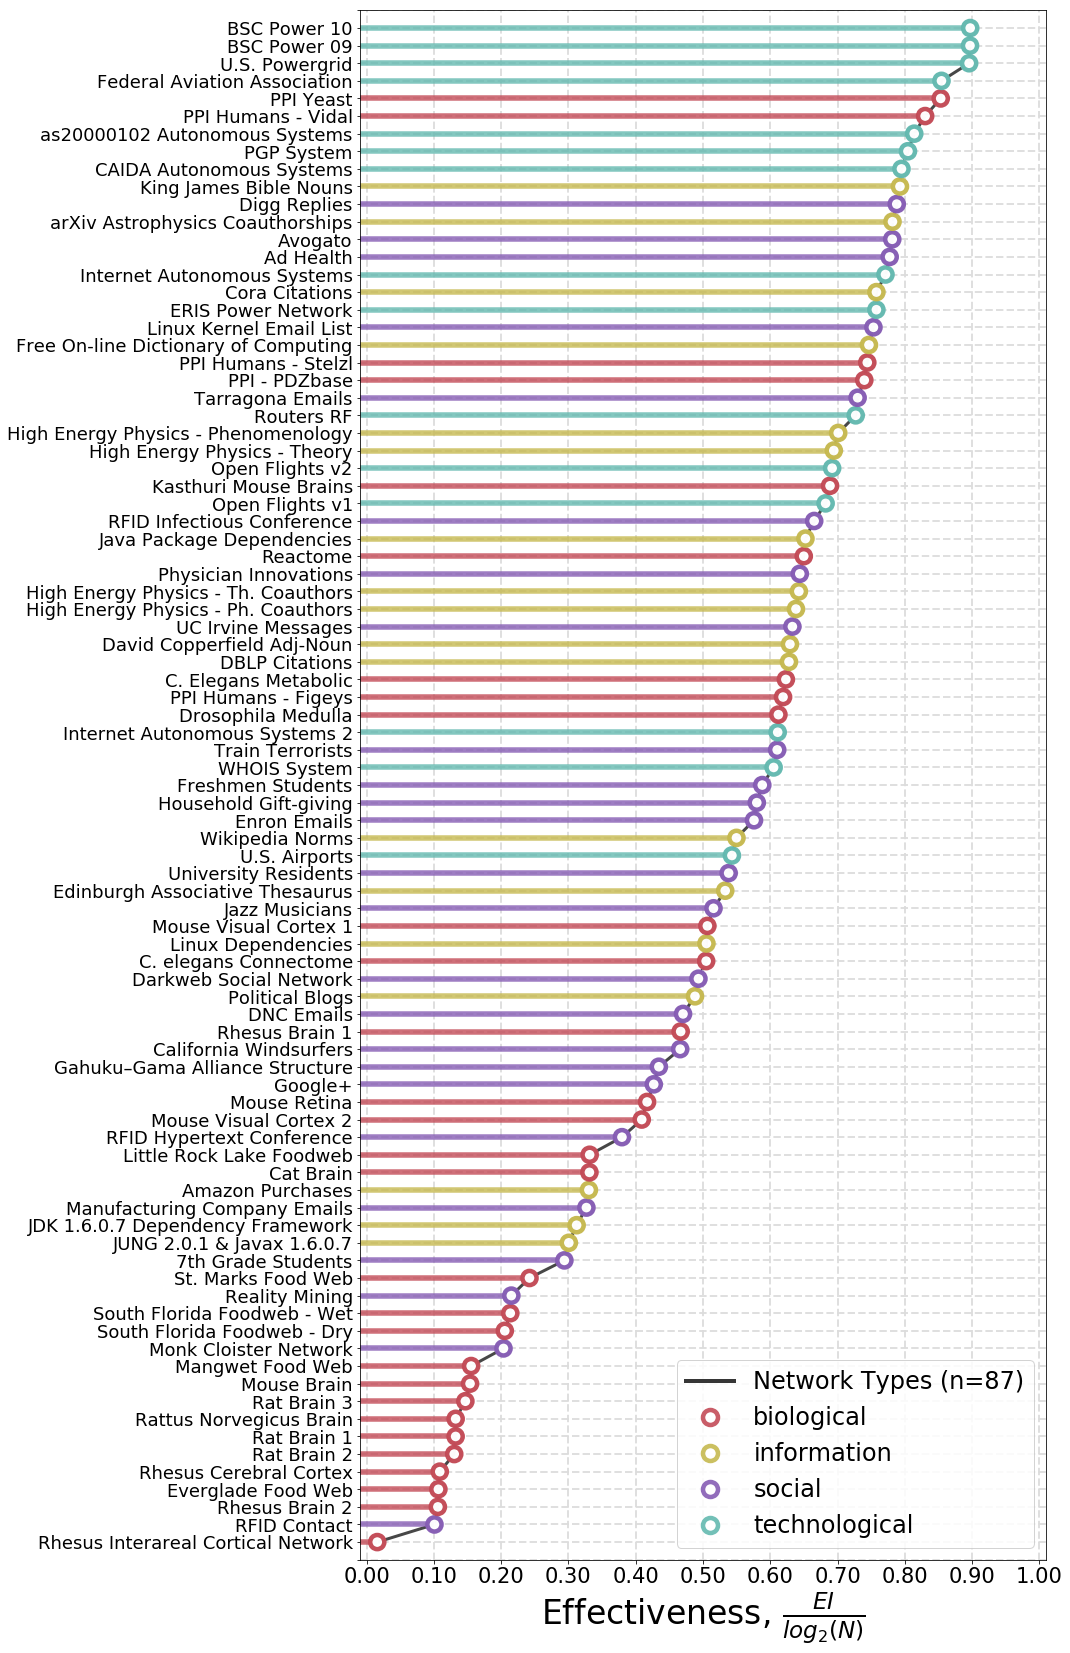

In [1109]:
konect_data_new = real_networks_dict
plt.rc('axes', axisbelow=True)

id_order = np.argsort(konect_data_new['effec'])
colors = np.array(konect_data_new['newco'])[id_order]
mult = 1.5

plt.figure(figsize=(8.2*mult,19*mult))

plt.plot([-10],[-10], marker='', 
         markersize=18, alpha=0.99, linestyle='-', linewidth=4.0,
         markeredgecolor='#333333', color='#333333', markeredgewidth=5.5, 
         markerfacecolor="w", label='Network Types (n=%i)'%len(konect_data_new['names']))

plt.hlines(sorted(id_order),-1,np.array(konect_data_new['effec'])[id_order], colors=colors, 
           linewidth=5.5, alpha=0.8, zorder=1)

plt.plot(np.array(konect_data_new['effec'])[id_order], sorted(id_order), alpha=0.9,
         marker='', linestyle='-', linewidth=3.0, color='#333333', zorder=0)

plt.scatter(np.array(konect_data_new['effec'])[id_order], sorted(id_order), 
            marker='o', s=200, alpha=0.98,
            edgecolors=colors, linewidths=4.5, facecolor="w")

for types, color in newco.items():
    plt.plot([-10],[-10], marker='o', 
         markersize=15, alpha=0.9, linestyle='', linewidth=3.0,
         markeredgecolor=color, markeredgewidth=4.5, 
         markerfacecolor="w", label=types)

ytix = np.linspace(-1,len(konect_data_new['names']),len(konect_data_new['names'])+2)
yticklist = [""]
for i in range(len(konect_data_new['names'])):
    yticklist.append(np.array(konect_data_new['names'])[id_order][i])
yticklist.append("")

plt.yticks(ytix, yticklist, rotation=0, size=12*mult)
plt.xticks(np.linspace(0,1,11), ["%.2f"%i for i in np.linspace(0,1,11)], size=14*mult)
plt.grid(alpha=0.9, color='gainsboro', linestyle='--', linewidth=2.0)
plt.ylim(-1,len(konect_data_new['names']))
plt.xlim(-0.01,1.01)
plt.xlabel(r'Effectiveness, $\frac{EI}{log_2(N)}$', size=22*mult)
plt.legend(loc=4, fontsize=16*mult, framealpha=0.85)

# plt.savefig("../figs/pngs/Konect_SortedEffectiveness_4colv.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Konect_SortedEffectiveness_4colv.pdf", bbox_inches='tight')
plt.show()

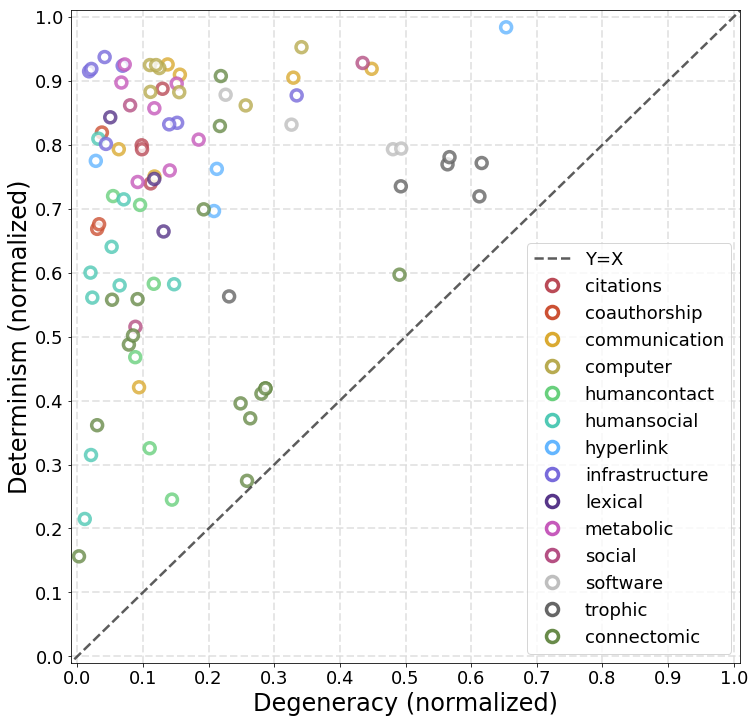

In [1155]:
konect_data = konect_data_new.copy()
fig, ax = plt.subplots(1, 1, figsize=(12,12))
plt.plot([-0.5, 20.5], [-0.5, 20.5], marker='', linestyle='--', 
            linewidth=2.5, color='#333333', label='Y=X', alpha=0.8)

ma = 'o'
si = 120
det = np.array(konect_data['deter'])
deg = np.array(konect_data['degen'])
eff = np.array(konect_data['effec'])
eis = np.array(konect_data['effin'])
id_order = np.argsort(eis)
col = np.array(konect_data['color'])
lab = np.array(konect_data['names'])
N   = np.array(konect_data['nodes'])

ax.scatter((deg/np.log2(N)), (det/np.log2(N)), marker=ma, s=si, 
           color='w', alpha=0.80, edgecolors=col, linewidths=3.5)

for i in col_mapping.keys():
    ax.plot([-10],[-10],marker=ma,markersize=si/10,label=i,color='w',linestyle='',
            markeredgecolor=col_mapping[i], markeredgewidth=3.5)

ax.set_xlabel("Degeneracy (normalized)", size=24)
ax.set_ylabel("Determinism (normalized)", size=24)
ax.set_xticks(np.round(np.linspace(0,1.0,11), 2))
ax.set_yticks(np.round(np.linspace(0,1.0,11), 2))
ax.set_xticklabels(np.round(np.linspace(0,1.0,11), 2), fontsize=18)
ax.set_yticklabels(np.round(np.linspace(0,1.0,11), 2), fontsize=18)
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(-0.01, 1.01)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)

ax.legend(fontsize=18, framealpha=0.8)

# plt.savefig("../figs/pngs/Konect_NormDeterm_NormDegen.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Konect_NormDeterm_NormDegen.pdf", bbox_inches='tight')
plt.show()

In [1146]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
plt.plot([-0.5, 20.5], [-0.5, 20.5], marker='', linestyle='--', 
            linewidth=2.5, color='#333333', label='Y=X', alpha=0.8)

ma = 'o'
si = 120
det = np.array(konect_data['deter'])
deg = np.array(konect_data['degen'])
eff = np.array(konect_data['effec'])
eis = np.array(konect_data['effin'])
# id_order = np.argsort(eis)
# id_order = np.argsort(eff)
col = np.array(konect_data['color'])
lab = np.array(konect_data['names'])
N   = np.array(konect_data['nodes'])

ax.scatter(np.log2(N), eis, marker=ma, s=si, 
           color='w', alpha=0.80, edgecolors=col, linewidths=3.5)
for i in col_mapping.keys():
    ax.plot([-10],[-10],marker=ma,markersize=si/10,label=i,color='w',linestyle='',
            markeredgecolor=col_mapping[i], markeredgewidth=3.5)
ax.set_xlabel("$log_2(N)$", size=24)
ax.set_ylabel("Effective Information", size=24)
ax.set_xticks(np.linspace(0,16,17))
ax.set_yticks(np.linspace(0,16,17))
ax.set_xticklabels(np.linspace(0,16,17,dtype=int), fontsize=18)
ax.set_yticklabels(np.linspace(0,16,17,dtype=int), fontsize=18)
ax.set_xlim(-0.15, 16.15)
ax.set_ylim(-0.15, 16.15)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)

ax.legend(fontsize=18, framealpha=0.8)
# ax.legend(bbox_to_anchor=(1.0,1.0), fontsize=16, framealpha=0.8)

# plt.savefig("../figs/pngs/Konect_EffectiveInfo_log2N.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Konect_EffectiveInfo_log2N.pdf", bbox_inches='tight')
plt.show()

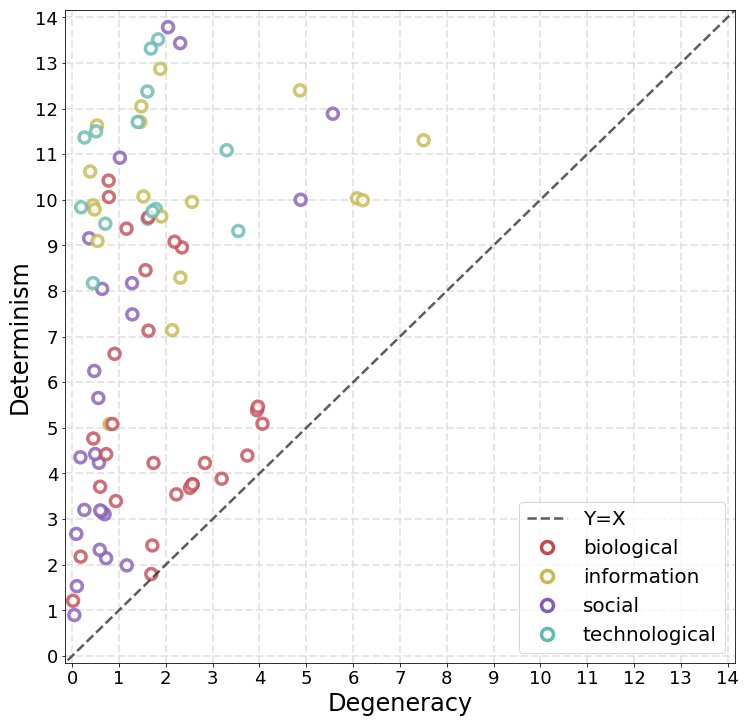

In [1157]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
plt.plot([-0.5, 20.5], [-0.5, 20.5], marker='', linestyle='--', 
            linewidth=2.5, color='#333333', label='Y=X', alpha=0.8)

ma = 'o'
si = 120
det = np.array(konect_data['deter'])
deg = np.array(konect_data['degen'])
eff = np.array(konect_data['effec'])
eis = np.array(konect_data['effin'])
id_order = np.argsort(eis)
col = np.array(konect_data['newco'])#[id_order]
lab = np.array(konect_data['names'])

ax.scatter((deg), (det), marker=ma, s=si, 
           color='w', alpha=0.80, edgecolors=col, linewidths=3.5)
for i in newco.keys():
    ax.plot([-10],[-10],marker=ma,markersize=si/10,label=i,color='w',linestyle='',
            markeredgecolor=newco[i], markeredgewidth=3.5)

ax.set_xlabel("Degeneracy", size=24)
ax.set_ylabel("Determinism", size=24)
ax.set_xticks(np.linspace(0,14,15))
ax.set_yticks(np.linspace(0,14,15))
ax.set_xticklabels(np.linspace(0,14,15,dtype=int), fontsize=18)
ax.set_yticklabels(np.linspace(0,14,15,dtype=int), fontsize=18)
ax.set_xlim(-0.15, 14.15)
ax.set_ylim(-0.15, 14.15)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)

ax.legend(fontsize=20, framealpha=0.8)

# plt.savefig("../figs/pngs/Konect_Determ_Degen_4col.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Konect_Determ_Degen_4col.pdf", bbox_inches='tight')
plt.show()

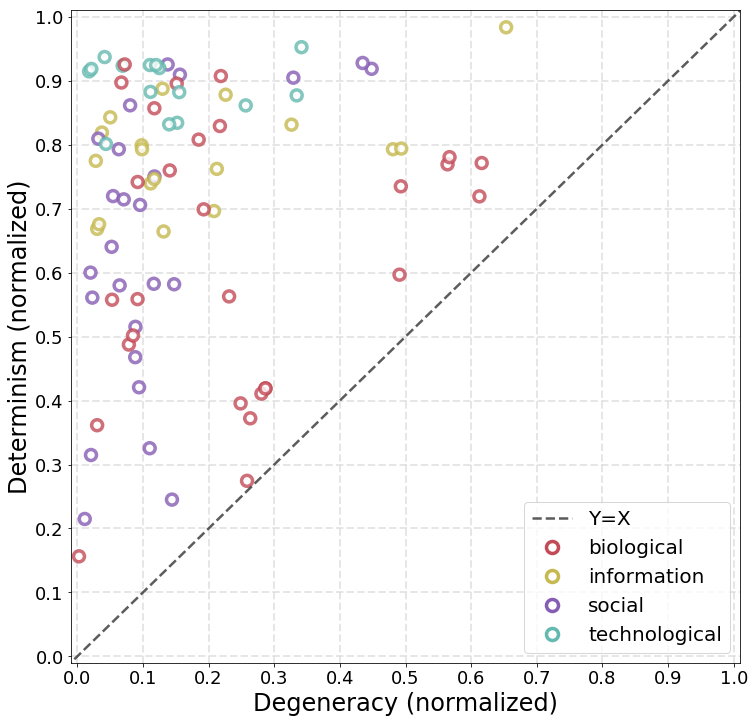

In [1154]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
plt.plot([-0.5, 20.5], [-0.5, 20.5], marker='', linestyle='--', 
            linewidth=2.5, color='#333333', label='Y=X', alpha=0.8)

ma = 'o'
si = 120
det = np.array(konect_data['deter'])
deg = np.array(konect_data['degen'])
eff = np.array(konect_data['effec'])
eis = np.array(konect_data['effin'])
id_order = np.argsort(eis)
col = np.array(konect_data['newco'])#[id_order]
lab = np.array(konect_data['names'])
N   = np.array(konect_data['nodes'])

ax.scatter((deg/np.log2(N)), (det/np.log2(N)), marker=ma, s=si, 
           color='w', alpha=0.80, edgecolors=col, linewidths=3.5)
for i in newco.keys():
    ax.plot([-10],[-10],marker=ma,markersize=si/10,label=i,color='w',linestyle='',
            markeredgecolor=newco[i], markeredgewidth=3.5)

ax.set_xlabel("Degeneracy (normalized)", size=24)
ax.set_ylabel("Determinism (normalized)", size=24)
ax.set_xticks(np.round(np.linspace(0,1.0,11), 2))
ax.set_yticks(np.round(np.linspace(0,1.0,11), 2))
ax.set_xticklabels(np.round(np.linspace(0,1.0,11), 2), fontsize=18)
ax.set_yticklabels(np.round(np.linspace(0,1.0,11), 2), fontsize=18)
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(-0.01, 1.01)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)

ax.legend(fontsize=20, framealpha=0.8)

# plt.savefig("../figs/pngs/Konect_NormDeterm_NormDegen_4col.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Konect_NormDeterm_NormDegen_4col.pdf", bbox_inches='tight')
plt.show()

In [1153]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
plt.plot([-0.5, 20.5], [-0.5, 20.5], marker='', linestyle='--', 
            linewidth=2.5, color='#333333', label='Y=X', alpha=0.8)

ma = 'o'
si = 120
det = np.array(konect_data['deter'])
deg = np.array(konect_data['degen'])
eff = np.array(konect_data['effec'])
eis = np.array(konect_data['effin'])
id_order = np.argsort(eis)
col = np.array(konect_data['newco'])#[id_order]
lab = np.array(konect_data['names'])
N   = np.array(konect_data['nodes'])

ax.scatter(np.log2(N), eis, marker=ma, s=si, 
           color='w', alpha=0.80, edgecolors=col, linewidths=3.5)
for i in newco.keys():
    ax.plot([-10],[-10],marker=ma,markersize=si/10,label=i,color='w',linestyle='',
            markeredgecolor=newco[i], markeredgewidth=3.5)

ax.set_xlabel("$log_2(N)$", size=24)
ax.set_ylabel("Effective Information", size=24)
ax.set_xticks(np.linspace(0,16,17))
ax.set_yticks(np.linspace(0,16,17))
ax.set_xticklabels(np.linspace(0,16,17,dtype=int), fontsize=18)
ax.set_yticklabels(np.linspace(0,16,17,dtype=int), fontsize=18)
ax.set_xlim(-0.15, 16.15)
ax.set_ylim(-0.15, 16.15)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)

ax.legend(fontsize=20, framealpha=0.8)
# ax.legend(bbox_to_anchor=(1.0,1.0), fontsize=16, framealpha=0.8)

# plt.savefig("../figs/pngs/Konect_EffectiveInfo_log2N_4col.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Konect_EffectiveInfo_log2N_4col.pdf", bbox_inches='tight')
plt.show()

In [1110]:
real_networks = pd.DataFrame(real_networks_dict)

In [1111]:
real_networks

color     degen      deter    edges     effec      effin  \
0   #ba4b57  1.479658  12.047861   421578  0.700984  10.568201   
1   #ba4b57  1.455544  11.705607   352807  0.694390  10.250063   
2   #ba4b57  1.883286  12.870240    91500  0.757736  10.986954   
3   #ba4b57  1.522936  10.073271    49743  0.627773   8.550336   
4   #cc5134  0.532844  11.628862   198050  0.781618  11.096018   
5   #cc5134  0.448587   9.879379  3148446  0.638168   9.430793   
6   #cc5134  0.481601   9.787133  2444797  0.642489   9.305532   
7   #daaa32  0.641991   8.046307     5451  0.729782   7.404319   
8   #daaa32  4.881334  10.000852     5598  0.470331   5.119516   
9   #daaa32  2.308754  13.434429   242976  0.753294  11.125673   
10  #daaa32  2.050018  13.783683    86403  0.787934  11.733665   
11  #daaa32  1.280462   8.172760    20295  0.632842   6.892297   
12  #daaa32  0.694847   3.107276     5784  0.326723   2.412427   
13  #b8ab51  1.836896  13.516881    53381  0.794971  11.679988   
14  #b8ab51  1.402222  11.706783    13895  0.813918  10.304562   
15  #b8ab51  1.682595  13.316146   114495  0.771191  11.633551   
16  #69d07d  1.168238   1.985445     2899  0.100914   0.817207   
17  #69d07d  0.726648   2.143469     2539  0.215160   1.416822   
18  #69d07d  0.632437   3.161656      335  0.466107   2.529218   
19  #69d07d  0.574064   4.235677      242  0.610269   3.661612   
20  #69d07d  0.602395   3.191022     2195  0.379554   2.588627   
21  #69d07d  0.473489   6.247285     2764  0.665224   5.773794   
22  #50c9b5  0.492436   4.426156     2742  0.515603   3.933720   
23  #50c9b5  0.363369   9.156196    12968  0.777435   8.792827   
24  #50c9b5  0.560253   5.655028     1098  0.643858   5.094775   
25  #50c9b5  0.177820   4.354571     2671  0.538134   4.176751   
26  #50c9b5  0.047578   0.896150      188  0.203498   0.848573   
27  #50c9b5  0.101699   1.529843      375  0.293979   1.428143   
28  #50c9b5  0.089844   2.676132       78  0.579960   2.586291   
29  #50c9b5  0.261791   3.202206      709  0.588083   2.940413   
..      ...       ...        ...      ...       ...        ...   
57  #698b4a  0.598252   3.709461      214  0.408975   3.111212   
58  #698b4a  2.572480   3.760474    27667  0.132376   1.187994   
59  #698b4a  2.517726   3.686948    30088  0.130284   1.169224   
60  #698b4a  2.227605   3.542502    33020  0.146847   1.314898   
61  #64b6ff  7.507114  11.304223     3904  0.330432   3.797107   
62  #bfbfbf  2.561498   9.954007     9391  0.652258   7.392510   
63  #b55083  5.568425  11.886464    25104  0.493236   6.318038   
64  #698b4a  0.453011   4.766726     5129  0.504711   4.313712   
65  #698b4a  0.182306   2.177033     1139  0.331220   1.994727   
66  #698b4a  2.346171   8.955563     9735  0.612067   6.609392   
67  #698b4a  2.188561   9.081172     1559  0.688777   6.892611   
68  #698b4a  0.020350   1.210132    21807  0.153824   1.189782   
69  #698b4a  0.860139   5.084893    90811  0.416924   4.224753   
70  #698b4a  2.572645   3.760930    27667  0.132408   1.188286   
71  #698b4a  0.727265   4.423958     4090  0.466821   3.696693   
72  #698b4a  3.194791   3.884462      628  0.105976   0.689671   
73  #698b4a  1.714671   2.422815     1615  0.108815   0.708144   
74  #698b4a  1.691208   1.795208     2667  0.015904   0.104000   
75  #64b6ff  2.312842   8.293239    17236  0.549729   5.980397   
76  #daaa32  5.402307  14.853131   321918  0.575805   9.450823   
77  #666666  3.742080   4.394178      915  0.106752   0.652098   
78  #666666  2.836564   4.230117      355  0.242151   1.393553   
79  #666666  4.065849   5.091686     1491  0.155432   1.025837   
80  #b8ab51  5.224133  14.568694    85123  0.611011   9.344562   
81  #b8ab51  1.606704  12.374252    24316  0.804592  10.767548   
82  #b8ab51  3.301982  11.086741    56943  0.604968   7.784759   
83  #b8ab51  1.715672   9.744736     6632  0.726936   8.029064   
84  #786bdb  0.445390   8.173761     9864  0.757708   7.728370   
85  #786bdb  0.193556   9.834967     4117  0.8

In [1171]:
rn_inf = real_networks[real_networks['newty']=='information']
rn_bio = real_networks[real_networks['newty']=='biological']
rn_soc = real_networks[real_networks['newty']=='social']
rn_tec = real_networks[real_networks['newty']=='technological']

In [1172]:
cols = [np.unique(rn_bio['newco'])[0],np.unique(rn_inf['newco'])[0],np.unique(rn_soc['newco'])[0],np.unique(rn_tec['newco'])[0]]

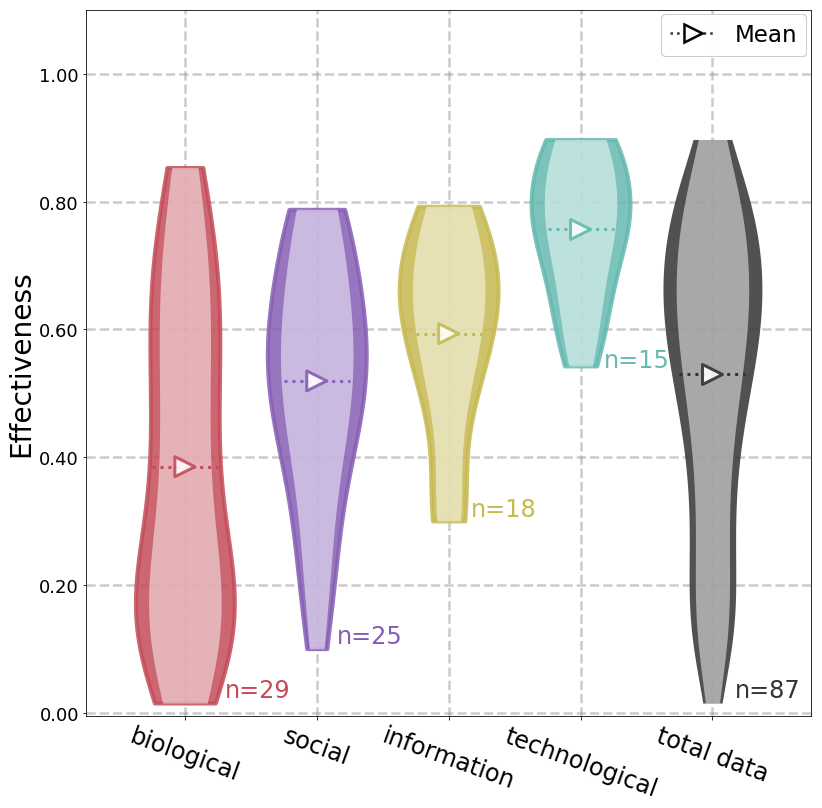

In [1209]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 13))

all_data = [np.array(rn_bio['effec']), np.array(rn_inf['effec']), np.array(rn_soc['effec']), np.array(rn_tec['effec'])]

parts = ax.violinplot(all_data, positions=[1,3,2,4], showmeans=False, showmedians=False, 
                      showextrema=False, widths=0.75)
for i in range(len(parts['bodies'])):
    pc = parts['bodies'][i]
    pc.set_edgecolor(cols[i])
    pc.set_facecolor(cols[i])
    pc.set_alpha(0.85)
    pc.set_linewidth(4.0)
parts = ax.violinplot(all_data, positions=[1,3,2,4], showmeans=False, showmedians=False, 
                      showextrema=False, widths=0.55)
for i in range(len(parts['bodies'])):
    pc = parts['bodies'][i]
    pc.set_edgecolor(cols[i])
    pc.set_facecolor('w')
    pc.set_alpha(0.5)
    pc.set_linewidth(0.0)

parts = ax.violinplot(real_networks['effec'], positions=[5], showmeans=False, showmedians=False, 
                      showextrema=False, widths=0.75)
for i in range(len(parts['bodies'])):
    pc = parts['bodies'][i]
    pc.set_edgecolor("#333333")
    pc.set_facecolor('#333333')
    pc.set_alpha(0.85)
    pc.set_linewidth(0.0)
parts = ax.violinplot(real_networks['effec'], positions=[5], showmeans=False, showmedians=False, 
                      showextrema=False, widths=0.55)
for i in range(len(parts['bodies'])):
    pc = parts['bodies'][i]
    pc.set_edgecolor("#333333")
    pc.set_facecolor('w')
    pc.set_alpha(0.5)
    pc.set_linewidth(0.0)

    
plt.hlines([np.mean(data) for data in all_data], [0.75, 2.75, 1.75, 3.75], [1.25, 3.25, 2.25, 4.25], 
           linestyles=':', colors=cols, zorder=1, linewidth=3)#, colors=cols)
# plt.hlines([np.median(data) for data in all_data], [0.75, 2.75, 1.75, 3.75], [1.25, 3.25, 2.25, 4.25], 
#            linestyles=':', colors=cols, zorder=1, linewidth=3)#, colors=cols)
plt.hlines([np.mean(real_networks['effec'])], [4.75], [5.25], 
           linestyles=':', colors='#333333', zorder=1, linewidth=3)#, colors=cols)
# plt.hlines([np.median(real_networks['effec'])], [4.75], [5.25], 
#            linestyles=':', colors='#333333', zorder=1, linewidth=3)#, colors=cols)

plt.plot(np.linspace(-10,-20,5), np.linspace(-10,-20,5), linestyle=':', marker='>', markersize=18, 
         markerfacecolor='w', color='#333333', linewidth=2.5, markeredgecolor='k', 
         markeredgewidth=2.5, label='Mean', alpha=0.98)
# plt.plot(np.linspace(-10,-20,5), np.linspace(-10,-20,5), linestyle=':', marker='<', markersize=18, 
#          markerfacecolor='w', color='#333333', linewidth=2.5, markeredgecolor='k', 
#          markeredgewidth=2.5, label='Median', alpha=0.98)

plt.scatter([1,3,2,4], [np.mean(data) for data in all_data], 
           marker='>', s=400, facecolor='w', edgecolors=cols, linewidths=3.0, alpha=0.9)
# plt.scatter([1,3,2,4], [np.median(data) for data in all_data], 
#            marker='<', s=400, facecolor='w', edgecolors=cols, linewidths=3.0, alpha=0.9)
plt.scatter([5], [np.mean(real_networks['effec'])], 
           marker='>', s=400, facecolor='w', edgecolors="#333333", linewidths=3.0, alpha=0.9)
# plt.scatter([5], [np.median(real_networks['effec'])], 
#            marker='<', s=400, facecolor='w', edgecolors="#333333", linewidths=3.0, alpha=0.9)

ax.set_ylabel('Effectiveness', fontsize=28)

ax.set_xticks([y+1 for y in range(len(all_data)+1)])
ax.set_xticklabels(['biological', 'social', 'information', 'technological', 'total data'], fontsize=24, rotation=340)
ax.set_yticks(np.linspace(0,1,6))
ax.set_yticklabels(["%.2f"%i for i in np.linspace(0,1,6)], fontsize=18)
ax.grid(True, linestyle='--', linewidth=2.5, color='#999999', alpha=0.5)

ax.text(1.30,0.025,"n=%i"%len(all_data[0]), fontsize=24, color=cols[0])
ax.text(3.17,0.309,"n=%i"%len(all_data[1]), fontsize=24, color=cols[1])
ax.text(2.15,0.110,"n=%i"%len(all_data[2]), fontsize=24, color=cols[2])
ax.text(4.175,0.541,"n=%i"%len(all_data[3]), fontsize=24, color=cols[3])
ax.text(5.17,0.025,"n=%i"%len(real_networks['effec']), fontsize=24, color="#333333")

# ax.legend(fontsize=22)
leg1 = ax.legend(bbox_to_anchor=(1.009,1.01), fontsize=23, ncol=1, columnspacing=2, framealpha=0.95)
ax.add_artist(leg1)
# ax.legend(bbox_to_anchor=(1.009,1.01), fontsize=20, ncol=1, columnspacing=2)
# ax.legend(bbox_to_anchor=(0.99,1.0), fontsize=18, ncol=1, columnspacing=2)
ax.set_ylim(-0.005, 1.1)
ax.set_xlim(0.25, 5.75)

plt.savefig("../figs/pngs/Konect_Effectiveness_Violin.png", dpi=425, bbox_inches='tight')
plt.savefig("../figs/pdfs/Konect_Effectiveness_Violin.pdf", bbox_inches='tight')
plt.show()

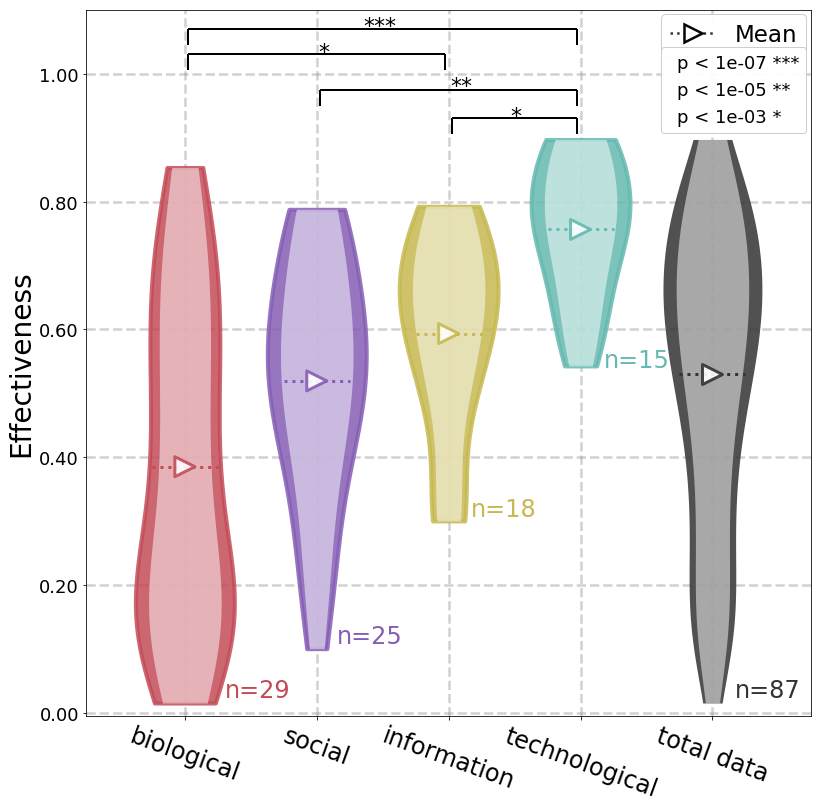

In [1211]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 13))

all_data = [np.array(rn_bio['effec']), np.array(rn_inf['effec']), np.array(rn_soc['effec']), np.array(rn_tec['effec'])]

parts = ax.violinplot(all_data, positions=[1,3,2,4], showmeans=False, showmedians=False, 
                      showextrema=False, widths=0.75)
for i in range(len(parts['bodies'])):
    pc = parts['bodies'][i]
    pc.set_edgecolor(cols[i])
    pc.set_facecolor(cols[i])
    pc.set_alpha(0.85)
    pc.set_linewidth(4.0)
parts = ax.violinplot(all_data, positions=[1,3,2,4], showmeans=False, showmedians=False, 
                      showextrema=False, widths=0.55)
for i in range(len(parts['bodies'])):
    pc = parts['bodies'][i]
    pc.set_edgecolor(cols[i])
    pc.set_facecolor('w')
    pc.set_alpha(0.5)
    pc.set_linewidth(0.0)

parts = ax.violinplot(real_networks['effec'], positions=[5], showmeans=False, showmedians=False, 
                      showextrema=False, widths=0.75)
for i in range(len(parts['bodies'])):
    pc = parts['bodies'][i]
    pc.set_edgecolor("#333333")
    pc.set_facecolor('#333333')
    pc.set_alpha(0.85)
    pc.set_linewidth(0.0)
parts = ax.violinplot(real_networks['effec'], positions=[5], showmeans=False, showmedians=False, 
                      showextrema=False, widths=0.55)
for i in range(len(parts['bodies'])):
    pc = parts['bodies'][i]
    pc.set_edgecolor("#333333")
    pc.set_facecolor('w')
    pc.set_alpha(0.5)
    pc.set_linewidth(0.0)

    
plt.hlines([np.mean(data) for data in all_data], [0.75, 2.75, 1.75, 3.75], [1.25, 3.25, 2.25, 4.25], 
           linestyles=':', colors=cols, zorder=1, linewidth=3)#, colors=cols)
# plt.hlines([np.median(data) for data in all_data], [0.75, 2.75, 1.75, 3.75], [1.25, 3.25, 2.25, 4.25], 
#            linestyles=':', colors=cols, zorder=1, linewidth=3)#, colors=cols)
plt.hlines([np.mean(real_networks['effec'])], [4.75], [5.25], 
           linestyles=':', colors='#333333', zorder=1, linewidth=3)#, colors=cols)
# plt.hlines([np.median(real_networks['effec'])], [4.75], [5.25], 
#            linestyles=':', colors='#333333', zorder=1, linewidth=3)#, colors=cols)

plt.plot(np.linspace(-10,-20,5), np.linspace(-10,-20,5), linestyle=':', marker='>', markersize=18, 
         markerfacecolor='w', color='#333333', linewidth=2.5, markeredgecolor='k', 
         markeredgewidth=2.5, label='Mean', alpha=0.98)
# plt.plot(np.linspace(-10,-20,5), np.linspace(-10,-20,5), linestyle=':', marker='<', markersize=18, 
#          markerfacecolor='w', color='#333333', linewidth=2.5, markeredgecolor='k', 
#          markeredgewidth=2.5, label='Median', alpha=0.98)

plt.scatter([1,3,2,4], [np.mean(data) for data in all_data], 
           marker='>', s=400, facecolor='w', edgecolors=cols, linewidths=3.0, alpha=0.9)
# plt.scatter([1,3,2,4], [np.median(data) for data in all_data], 
#            marker='<', s=400, facecolor='w', edgecolors=cols, linewidths=3.0, alpha=0.9)
plt.scatter([5], [np.mean(real_networks['effec'])], 
           marker='>', s=400, facecolor='w', edgecolors="#333333", linewidths=3.0, alpha=0.9)
# plt.scatter([5], [np.median(real_networks['effec'])], 
#            marker='<', s=400, facecolor='w', edgecolors="#333333", linewidths=3.0, alpha=0.9)

ax.set_ylabel('Effectiveness', fontsize=28)

ax.set_xticks([y+1 for y in range(len(all_data)+1)])
ax.set_xticklabels(['biological', 'social', 'information', 'technological', 'total data'], fontsize=24, rotation=340)
ax.set_yticks(np.linspace(0,1,6))
ax.set_yticklabels(["%.2f"%i for i in np.linspace(0,1,6)], fontsize=18)
ax.grid(True, linestyle='--', linewidth=2.5, color='#999999', alpha=0.45)

ax.text(1.30,0.025,"n=%i"%len(all_data[0]), fontsize=24, color=cols[0])
ax.text(3.17,0.309,"n=%i"%len(all_data[1]), fontsize=24, color=cols[1])
ax.text(2.15,0.110,"n=%i"%len(all_data[2]), fontsize=24, color=cols[2])
ax.text(4.175,0.541,"n=%i"%len(all_data[3]), fontsize=24, color=cols[3])
ax.text(5.17,0.025,"n=%i"%len(real_networks['effec']), fontsize=24, color="#333333")

ax.text(2.35,1.065,"***", fontsize=22)
# ax.text(2.05,1.01,"p < %.0e"%sp.stats.ttest_ind(all_data[labs['biological']], 
#                                                 all_data[labs['technological']], equal_var=False)[1], fontsize=18)
ax.hlines(1.07, labs['biological']+1+0.025, labs['technological']+1-0.025, linewidth=2.0)
ax.vlines(labs['biological']+1+0.025, 1.045, 1.07, linewidth=2.0)
ax.vlines(labs['technological']+1-0.025, 1.045, 1.07, linewidth=2.0)

ax.text(2.015,1.025,"*", fontsize=22)
# ax.text(1.65,0.961,"p < %.0e"%sp.stats.ttest_ind(all_data[labs['biological']], 
#                                                 all_data[labs['information']], equal_var=False)[1], fontsize=18)
ax.hlines(1.03, labs['biological']+1+0.025, labs['information']+1+1-0.025, linewidth=2.0)
ax.vlines(labs['biological']+1+0.025, 1.005, 1.03, linewidth=2.0)
ax.vlines(labs['information']+1+1-0.025, 1.005, 1.03, linewidth=2.0)

ax.text(3.01,0.972,"**", fontsize=22)
# ax.text(3.41,0.925,"p < %.0e"%sp.stats.ttest_ind(all_data[labs['technological']], 
#                                                  all_data[labs['social']], equal_var=False)[1], fontsize=18)
ax.hlines(0.975, labs['social']+0.025, labs['technological']+1-0.025, linewidth=2.0)
ax.vlines(labs['social']+0.025, 0.95, 0.975, linewidth=2.0)
ax.vlines(labs['technological']+1-0.025, 0.95, 0.975, linewidth=2.0)

ax.text(3.47,0.925,"*", fontsize=22)
# ax.text(3.41,0.925,"p < %.0e"%sp.stats.ttest_ind(all_data[labs['technological']], 
#                                                  all_data[labs['information']], equal_var=False)[1], fontsize=18)
ax.hlines(0.93, labs['information']+2+0.025, labs['technological']+1-0.025, linewidth=2.0)
ax.vlines(labs['information']+2+0.025, 0.905, 0.93, linewidth=2.0)
ax.vlines(labs['technological']+1-0.025, 0.905, 0.93, linewidth=2.0)


x1 = ax.plot([], [], marker='.', linestyle='', c='w')
x2 = ax.plot([], [], marker='.', linestyle='', c='w')
x3 = ax.plot([], [], marker='.', linestyle='', c='w')
legs=[x1,x2,x3]
leg1 = ax.legend(bbox_to_anchor=(1.009,1.01), fontsize=23, ncol=1, columnspacing=2, framealpha=0.95)
ax.legend([l[0] for l in legs], ["p < 1e-07 ***","p < 1e-05 **","p < 1e-03 *"], handletextpad=-1.525,
          bbox_to_anchor=(1.0055,0.96), fontsize=18, ncol=1, columnspacing=-3.75, framealpha=0.95)
ax.add_artist(leg1)
ax.set_ylim(-0.005, 1.1)
ax.set_xlim(0.25, 5.75)

# plt.savefig("../figs/pngs/Konect_Effectiveness_Violin_stats.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Konect_Effectiveness_Violin_stats.pdf", bbox_inches='tight')
plt.show()

In [1177]:
labs = {'biological':0,'social':2,"information":1,'technological':3}
a = labs['biological']
b = labs['social']

for lab1 in labs.keys():
    a = labs[lab1]
    for lab2 in labs.keys():
        b = labs[lab2]
        if a!=b:
            t,p = sp.stats.ttest_ind(all_data[a], all_data[b], equal_var=False)
            print("comparing",lab1,"       \t", "to \t ",lab2,"       \t t-statistic = %.7f, \t p < %.8f"%(t,p))

comparing biological        	 to 	  social        	 t-statistic = -2.1981071, 	 p < 0.03251003
comparing biological        	 to 	  information        	 t-statistic = -3.4526127, 	 p < 0.00121980
comparing biological        	 to 	  technological        	 t-statistic = -6.6516903, 	 p < 0.00000005
comparing social        	 to 	  biological        	 t-statistic = 2.1981071, 	 p < 0.03251003
comparing social        	 to 	  information        	 t-statistic = -1.3930397, 	 p < 0.17125986
comparing social        	 to 	  technological        	 t-statistic = -4.9459823, 	 p < 0.00001572
comparing information        	 to 	  biological        	 t-statistic = 3.4526127, 	 p < 0.00121980
comparing information        	 to 	  social        	 t-statistic = 1.3930397, 	 p < 0.17125986
comparing information        	 to 	  technological        	 t-statistic = -3.4749085, 	 p < 0.00156001
comparing technological        	 to 	  biological        	 t-statistic = 6.6516903, 	 p < 0.00000005
comparing technol

In [324]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')

In [ ]:
plt.rc('axes', axisbelow=True)

id_order = np.argsort(konect_data_new['effec'])
colors = np.array(konect_data_new['newco'])[id_order]
mult = 1.4

plt.figure(figsize=(19*mult,8.2*mult))

plt.plot([-10],[-10], marker='', 
         markersize=18, alpha=0.99, linestyle='-', linewidth=4.0,
         markeredgecolor='#333333', color='#333333', markeredgewidth=5.5, 
         markerfacecolor="w", label='Network Types')

plt.vlines(sorted(id_order),-1,np.array(konect_data_new['effec'])[id_order], colors=colors, 
           linewidth=4.0, alpha=0.8, zorder=1)

plt.plot(sorted(id_order), np.array(konect_data_new['effec'])[id_order], alpha=0.9,
         marker='', linestyle='-', linewidth=3.0, color='#333333', zorder=0)

plt.scatter(sorted(id_order), np.array(konect_data_new['effec'])[id_order], 
            marker='o', s=200, alpha=0.98,
            edgecolors=colors, linewidths=4.5, facecolor="w")

for types, color in newco.items():
    plt.plot([-10],[-10], marker='o', 
         markersize=15, alpha=0.9, linestyle='', linewidth=3.0,
         markeredgecolor=color, markeredgewidth=4.5, 
         markerfacecolor="w", label=types)

xtix = np.linspace(-1,len(konect_data_new['names']),len(konect_data_new['names'])+2)
xticklist = [""]
for i in range(len(konect_data_new['names'])):
    xticklist.append(np.array(konect_data_new['names'])[id_order][i])
xticklist.append("")

plt.xticks(xtix, xticklist, rotation=270, size=14*mult)
plt.yticks(np.linspace(0,1,11), ["%.2f"%i for i in np.linspace(0,1,11)], size=18*mult)
plt.grid(alpha=0.9, color='gainsboro', linestyle='--', linewidth=2.0)
plt.xlim(-1,len(konect_data_new['names']))
plt.ylim(-0.01,1.01)
plt.ylabel(r'Effectiveness, $\frac{EI}{log_2(N)}$', size=26*mult)
plt.legend(loc=2, fontsize=18*mult, framealpha=0.85)

# plt.savefig("../figs/pngs/Konect_SortedEffectiveness_4col.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Konect_SortedEffectiveness_4col.pdf", bbox_inches='tight')
plt.show()

In [1113]:
# real_networks.to_csv("../data/konect_data/konect_csv.csv")
# real_networks[real_networks['nodes']<2000].to_csv("../data/konect_data/konect_csv_N2000.csv")

In [1102]:
real_networks.sort_values('num')
real_networks[real_networks['newty']=='technological']

color     degen      deter   edges     effec      effin  \
13  #b8ab51  1.836896  13.516881   53381  0.794971  11.679988   
14  #b8ab51  1.402222  11.706783   13895  0.813918  10.304562   
15  #b8ab51  1.682595  13.316146  114495  0.771191  11.633551   
33  #786bdb  0.709753   9.475836    2615  0.854415   8.766083   
34  #786bdb  1.786579   9.797160   37595  0.682223   8.010581   
35  #786bdb  1.613330   9.585048   30501  0.691923   7.971718   
36  #786bdb  0.511574  11.499830    6594  0.895495  10.988256   
37  #786bdb  3.549641   9.316252   28235  0.542984   5.766610   
4   #b8ab51  5.224133  14.568694   85123  0.611011   9.344562   
5   #b8ab51  1.606704  12.374252   24316  0.804592  10.767548   
6   #b8ab51  3.301982  11.086741   56943  0.604968   7.784759   
7   #b8ab51  1.715672   9.744736    6632  0.726936   8.029064   
8   #786bdb  0.445390   8.173761    9864  0.757708   7.728370   
9   #786bdb  0.193556   9.834967    4117  0.896816   9.641411   
10  #786bdb  0.266165  11.365039   13571  0.897112  11.098874   

                            names    newco          newty  nodes  num  \
13       CAIDA Autonomous Systems  #64b9b0  technological  26475   13   
14  as20000102 Autonomous Systems  #64b9b0  technological   6474   14   
15    Internet Autonomous Systems  #64b9b0  technological  34761   15   
33   Federal Aviation Association  #64b9b0  technological   1226   33   
34                Open Flights v1  #64b9b0  technological   3425   34   
35                Open Flights v2  #64b9b0  technological   2939   35   
36                 U.S. Powergrid  #64b9b0  technological   4941   36   
37                  U.S. Airports  #64b9b0  technological   1574   37   
4   Internet Autonomous Systems 2  #64b9b0  technological  40164   80   
5                      PGP System  #64b9b0  technological  10680   81   
6                    WHOIS System  #64b9b0  technological   7476   82   
7                      Routers RF  #64b9b0  technological   2113   83   
8              ERIS Power Network  #64b9b0  technological   1176   84   
9                    BSC Power 09  #64b9b0  technological   1723   85   
10                   BSC Power 10  #64b9b0  technological   5300   86   

             types  
13        computer  
14        computer  
15        computer  
33  infrastructure  
34  infrastructure  
35  infrastructure  
36  infrastructure  
37  infrastructure  
4         computer  
5         computer  
6         computer  
7         computer  
8   infrastructure  
9   infrastructure  
10  infrastructure

In [1011]:
ee = {'color': ['#daaa32','#666666','#666666', '#666666'],
      'degen': [5.402307203399426,3.7420799421263427,2.8365639039688202,4.0658487224702853],
      'deter': [14.853130630766957,4.3941779775930669,4.2301169547565962,5.0916855236632736],
      'edges': [321918,915,355,1491],
      'effec': [0.5758045914968972,0.10675213631061756,0.24215122367967915,0.15543187095377445],
      'effin': [9.45082342737,0.65209803546672418,1.393553050787776,1.0258368011929884],
      'names': ['Enron Emails','Everglade Food Web','St. Marks Food Web','Mangwet Food Web'],
      'newco': ['#865db4','#c34b57','#c34b57','#c34b57'],
      'newty': ['social','biological','biological','biological'],
      'nodes': [87273,69,54,97],
      'num':   [76,77,78,79],
      'types': ['communication','trophic','trophic','trophic']}

In [1097]:
internet = {'color': '#786bdb',
 'degen': 0.26616528801108252,
 'deter': 11.365038946064004,
 'edges': 13571,
 'effec': 0.89711235315038362,
 'effin': 11.098873658052952,
 'names': 'BSC Power 10',
 'newco': '#64b9b0',
 'newty': 'technological',
 'nodes': 5300,
 'num': 86,
 'types': 'infrastructure'}

In [1098]:
for i in internet.keys():
    ee[i].append(internet[i])
    
ee

{'color': ['#daaa32',
  '#666666',
  '#666666',
  '#666666',
  '#b8ab51',
  '#b8ab51',
  '#b8ab51',
  '#b8ab51',
  '#786bdb',
  '#786bdb',
  '#786bdb'],
 'degen': [5.402307203399426,
  3.7420799421263427,
  2.83656390396882,
  4.065848722470285,
  5.224132559765382,
  1.60670396991436,
  3.3019817103597955,
  1.7156720528909641,
  0.44539016878200677,
  0.19355580063544942,
  0.2661652880110825],
 'deter': [14.853130630766957,
  4.394177977593067,
  4.230116954756596,
  5.091685523663274,
  14.568694453404126,
  12.37425215569958,
  11.086740827182828,
  9.744736430733383,
  8.173760661044593,
  9.834966661733148,
  11.365038946064004],
 'edges': [321918,
  915,
  355,
  1491,
  85123,
  24316,
  56943,
  6632,
  9864,
  4117,
  13571],
 'effec': [0.5758045914968972,
  0.10675213631061756,
  0.24215122367967915,
  0.15543187095377445,
  0.6110106530136924,
  0.8045916977420424,
  0.6049680099420305,
  0.726936022273907,
  0.7577077214813788,
  0.896816448764851,
  0.8971123531503836],


In [1099]:
new_shit = pd.DataFrame(ee)

In [1100]:
real_networks = real_networks.append(new_shit, sort=True)
real_networks = real_networks[real_networks.duplicated()!=True]
real_networks

color     degen      deter    edges     effec      effin  \
0   #ba4b57  1.479658  12.047861   421578  0.700984  10.568201   
1   #ba4b57  1.455544  11.705607   352807  0.694390  10.250063   
2   #ba4b57  1.883286  12.870240    91500  0.757736  10.986954   
3   #ba4b57  1.522936  10.073271    49743  0.627773   8.550336   
4   #cc5134  0.532844  11.628862   198050  0.781618  11.096018   
5   #cc5134  0.448587   9.879379  3148446  0.638168   9.430793   
6   #cc5134  0.481601   9.787133  2444797  0.642489   9.305532   
7   #daaa32  0.641991   8.046307     5451  0.729782   7.404319   
8   #daaa32  4.881334  10.000852     5598  0.470331   5.119516   
9   #daaa32  2.308754  13.434429   242976  0.753294  11.125673   
10  #daaa32  2.050018  13.783683    86403  0.787934  11.733665   
11  #daaa32  1.280462   8.172760    20295  0.632842   6.892297   
12  #daaa32  0.694847   3.107276     5784  0.326723   2.412427   
13  #b8ab51  1.836896  13.516881    53381  0.794971  11.679988   
14  #b8ab51  1.402222  11.706783    13895  0.813918  10.304562   
15  #b8ab51  1.682595  13.316146   114495  0.771191  11.633551   
16  #69d07d  1.168238   1.985445     2899  0.100914   0.817207   
17  #69d07d  0.726648   2.143469     2539  0.215160   1.416822   
18  #69d07d  0.632437   3.161656      335  0.466107   2.529218   
19  #69d07d  0.574064   4.235677      242  0.610269   3.661612   
20  #69d07d  0.602395   3.191022     2195  0.379554   2.588627   
21  #69d07d  0.473489   6.247285     2764  0.665224   5.773794   
22  #50c9b5  0.492436   4.426156     2742  0.515603   3.933720   
23  #50c9b5  0.363369   9.156196    12968  0.777435   8.792827   
24  #50c9b5  0.560253   5.655028     1098  0.643858   5.094775   
25  #50c9b5  0.177820   4.354571     2671  0.538134   4.176751   
26  #50c9b5  0.047578   0.896150      188  0.203498   0.848573   
27  #50c9b5  0.101699   1.529843      375  0.293979   1.428143   
28  #50c9b5  0.089844   2.676132       78  0.579960   2.586291   
29  #50c9b5  0.261791   3.202206      709  0.588083   2.940413   
..      ...       ...        ...      ...       ...        ...   
57  #698b4a  0.598252   3.709461      214  0.408975   3.111212   
58  #698b4a  2.572480   3.760474    27667  0.132376   1.187994   
59  #698b4a  2.517726   3.686948    30088  0.130284   1.169224   
60  #698b4a  2.227605   3.542502    33020  0.146847   1.314898   
61  #64b6ff  7.507114  11.304223     3904  0.330432   3.797107   
62  #bfbfbf  2.561498   9.954007     9391  0.652258   7.392510   
63  #b55083  5.568425  11.886464    25104  0.493236   6.318038   
64  #698b4a  0.453011   4.766726     5129  0.504711   4.313712   
65  #698b4a  0.182306   2.177033     1139  0.331220   1.994727   
66  #698b4a  2.346171   8.955563     9735  0.612067   6.609392   
67  #698b4a  2.188561   9.081172     1559  0.688777   6.892611   
68  #698b4a  0.020350   1.210132    21807  0.153824   1.189782   
69  #698b4a  0.860139   5.084893    90811  0.416924   4.224753   
70  #698b4a  2.572645   3.760930    27667  0.132408   1.188286   
71  #698b4a  0.727265   4.423958     4090  0.466821   3.696693   
72  #698b4a  3.194791   3.884462      628  0.105976   0.689671   
73  #698b4a  1.714671   2.422815     1615  0.108815   0.708144   
74  #698b4a  1.691208   1.795208     2667  0.015904   0.104000   
75  #64b6ff  2.312842   8.293239    17236  0.549729   5.980397   
0   #daaa32  5.402307  14.853131   321918  0.575805   9.450823   
1   #666666  3.742080   4.394178      915  0.106752   0.652098   
2   #666666  2.836564   4.230117      355  0.242151   1.393553   
3   #666666  4.065849   5.091686     1491  0.155432   1.025837   
4   #b8ab51  5.224133  14.568694    85123  0.611011   9.344562   
5   #b8ab51  1.606704  12.374252    24316  0.804592  10.767548   
6   #b8ab51  3.301982  11.086741    56943  0.604968   7.784759   
7   #b8ab51  1.715672   9.744736     6632  0.726936   8.029064   
8   #786bdb  0.445390   8.173761     9864  0.757708   7.728370   
9   #786bdb  0.193556   9.834967     4117  0.8